In [1]:
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import straxen
import strax
from tqdm import tqdm
from scipy.stats import binom
import pandas as pd
import math
import sys
import combpile
import s1pattern
import spectrums

sys.path.append('/home/yuanlq/combpile')

# devlop average pattern

In [2]:
s1_pattern_map = s1pattern.make_map(map_file="/home/yuanlq/software/private_nt_aux_files/sim_files/XENONnT_s1_xyz_patterns_LCE_corrected_qes_MCva43fa9b_wires.pkl", fmt=None, method='WeightedNearestNeighbors')
xs = np.linspace(-64.18666666666667, 64.18666666666667, 30)
ys = np.linspace(-64.18666666666667, 64.18666666666667, 30)
zs = np.linspace(-153.4992099, 6.526389900000001, 100)

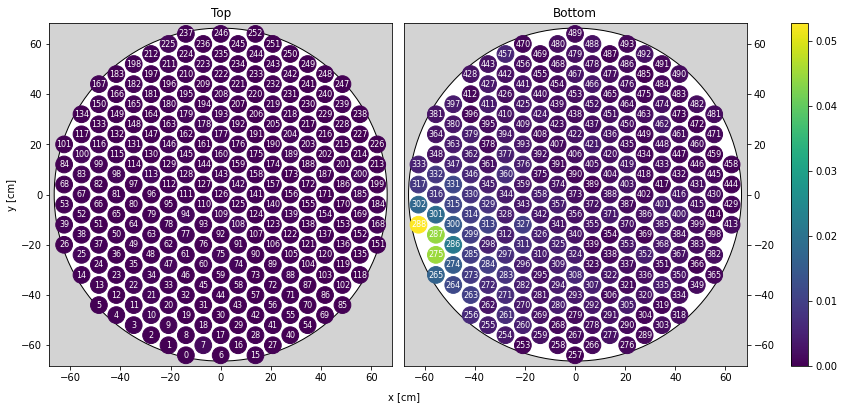

In [4]:
indices = (0,10,0)
s1_pattern = s1_pattern_map.data['map'][indices[0],indices[1],indices[2],:]
norm = 1/s1_pattern.sum()
straxen.plot_pmts(norm*s1_pattern)

In [5]:
np.shape(s1_pattern_map.data['map'])

(30, 30, 100, 494)

Some index are dummy in x-y because in principle they are outside TPC.

In [6]:
def inside_tpc_xy_indicies(s1_pattern_map, fv_radius=60.73, 
                           xs = np.linspace(-64.18666666666667, 64.18666666666667, 30)):
    len_x, len_y = np.shape(s1_pattern_map.data['map'])[:2]
    test_z_ind = 0
    first = True
    for i in range(len_x):
        for j in range(len_y):
            s1pattern = s1_pattern_map.data['map'][i,j,test_z_ind,:]
            check = s1pattern.sum()
            if check != 0 and xs[i]**2+xs[j]**2<fv_radius**2: # in Fiducial Volume radius
                if first:
                    good_xy_indicies = np.array([i, j])
                    first = False
                else:
                    good_xy_indicies = np.vstack((good_xy_indicies, np.array([i,j]))) 
    return good_xy_indicies

In [7]:
def coarse_grain_pattern(s1_pattern_map, good_xy_indicies, z_range, top=True,
                         zs = np.linspace(-153.4992099, 6.526389900000001, 100),
                         occ_bins = np.linspace(0,0.025,50)):
    s1_pattern = s1_pattern_map.data['map']

    z_left_index = np.digitize(z_range[0],zs)
    z_right_index = np.digitize(z_range[1],zs)+1
    len_z = z_right_index - z_left_index
    n_voxels = len_z*len(good_xy_indicies)
    
    counts_avg = np.zeros(len(occ_bins)-1)
    
    for z_ind in range(z_left_index, z_right_index):
        for xy_pair in good_xy_indicies:
            if top:
                pattern = s1_pattern[xy_pair[0],xy_pair[1],z_ind,:253]
            else:
                pattern = s1_pattern[xy_pair[0],xy_pair[1],z_ind,253:]
            pattern = pattern/pattern.sum() # normalization
            
            counts,_ = np.histogram(pattern, bins=occ_bins)
            counts = counts/counts.sum()
            counts_avg += counts/n_voxels # Assuming each voxel contribute equally
            
    return counts_avg
            
            

In [8]:
good_xy_indicies = inside_tpc_xy_indicies(s1_pattern_map, fv_radius=60.73, 
                           xs = np.linspace(-64.18666666666667, 64.18666666666667, 30))
occ_bins = np.linspace(0,0.025,50)
occs = (occ_bins[1:] + occ_bins[:-1])/2
z_range_fv = np.linspace(-134.238, -13.6132, 11)

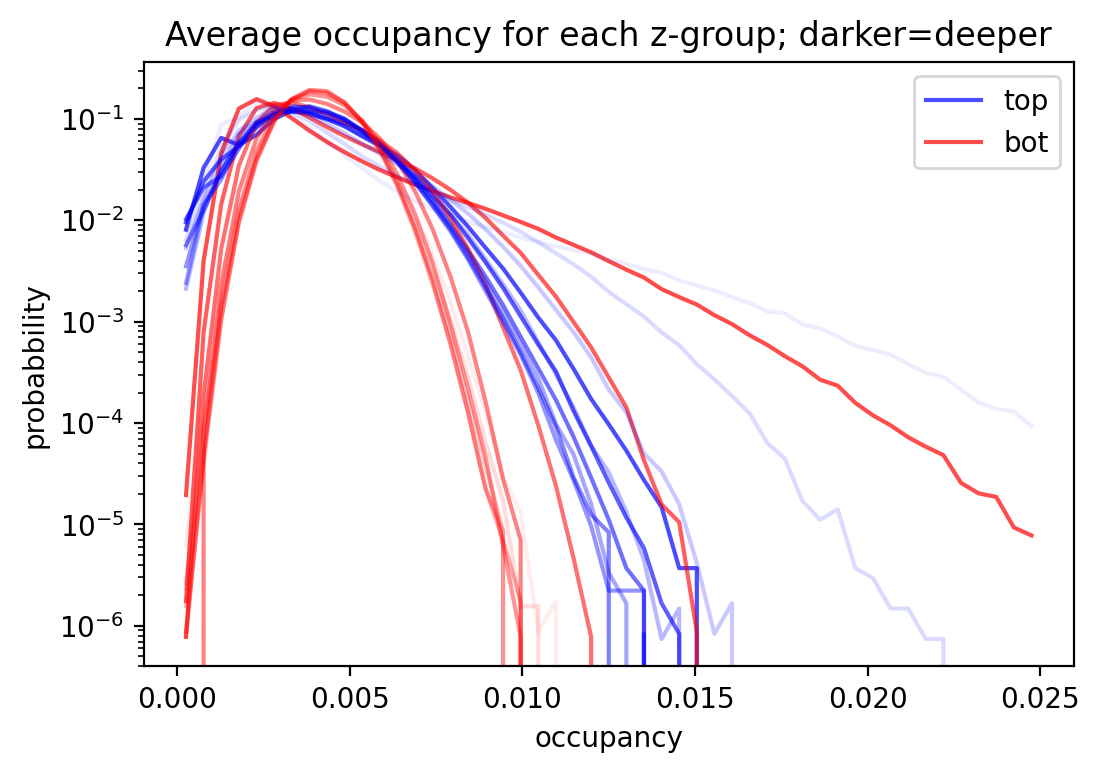

In [9]:
plt.figure(dpi=200)
for z_range_ind in range(10):
    if z_range_ind==0:
        counts_avg = coarse_grain_pattern(s1_pattern_map, good_xy_indicies, 
                                          z_range_fv[z_range_ind:z_range_ind+2])
        plt.plot(occs, counts_avg, alpha=0.7-z_range_ind*0.07, color='b', label='top')
        counts_avg = coarse_grain_pattern(s1_pattern_map, good_xy_indicies, 
                                          z_range_fv[z_range_ind:z_range_ind+2],top=False)
        plt.plot(occs, counts_avg, alpha=0.7-z_range_ind*0.07, color='r', label='bot')

    else:
        counts_avg = coarse_grain_pattern(s1_pattern_map, good_xy_indicies, 
                                          z_range_fv[z_range_ind:z_range_ind+2])
        plt.plot(occs, counts_avg, alpha=0.7-z_range_ind*0.07, color='b')
        counts_avg = coarse_grain_pattern(s1_pattern_map, good_xy_indicies, 
                                          z_range_fv[z_range_ind:z_range_ind+2],top=False)
        plt.plot(occs, counts_avg, alpha=0.7-z_range_ind*0.07, color='r')
plt.xlabel('occupancy')
plt.yscale('log')
plt.ylabel('probabbility')
plt.title('Average occupancy for each z-group; darker=deeper')
plt.legend()

Then we use the curves above to assign the 494 channels with individual occupancies.

In [10]:
def get_pattern(z_range, top, method='WeightedNearestNeighbors', fv_radius=60.73, 
                map_file="/home/yuanlq/software/private_nt_aux_files/sim_files/XENONnT_s1_xyz_patterns_LCE_corrected_qes_MCva43fa9b_wires.pkl", 
                xs = np.linspace(-64.18666666666667, 64.18666666666667, 30), 
                zs = np.linspace(-153.4992099, 6.526389900000001, 100),
                occ_bins = np.linspace(0,0.025,50), n_top_ch=250, n_bot_ch=234):
    """Find the average occupancy distribution for all channels in a certain array. The average is done over all voxels in a certain z range.

    Args:
        z_range (tuple): (minimum height, maximum height) in unit of cm, for the volume to be averaged.
        top (bool): whether or not we specify top array. 
        method (str, optional): interpolation method for s1 pattern map. Defaults to 'WeightedNearestNeighbors'.
        fv_radius (float, optional): Radius of fiducial volume. Defaults to 60.73 cm.
        map_file (str, optional): path to s1 pattern map. . Defaults to "/home/yuanlq/software/private_nt_aux_files/sim_files/XENONnT_s1_xyz_patterns_LCE_corrected_qes_MCva43fa9b_wires.pkl".
        xs (1darray, optional): values for x,y coodinates corresponding to indicies. Defaults to np.linspace(-64.18666666666667, 64.18666666666667, 30).
        zs (1darray, optional): the coodinates in unit of cm for the height range corresponding to the s1 pattern map you feed. Defaults to np.linspace(-153.4992099, 6.526389900000001, 100).
        occ_bins (1darray, optional): bins where the histogram for occupancy in built. Defaults to np.linspace(0,0.025,50).
        n_top_ch (int, optional): number of top array channels. Assign this to 1/occupancy in case of uneven S1 pattern. Defaults to 250.
        n_bot_ch (int, optional): number of bottom array channels. Assign this to 1/occupancy in case of uneven S1 pattern. Defaults to 234.

    Returns:
        occupancies (1darray): probability of one specific channel sees one photon when 1 phd is overseved in certain array.
        degeneracies (1darray): number of channels in a certain array see has the corresponding occupancy.
    """
    s1_pattern_map = make_map(map_file=map_file, fmt=None, method=method)
    good_xy_indicies = inside_tpc_xy_indicies(s1_pattern_map=s1_pattern_map, fv_radius=fv_radius, xs = xs)
    occupancies = (occ_bins[1:] + occ_bins[:-1])/2 # occupancy values as the middle of occupancy bins
    counts_avg = coarse_grain_pattern(s1_pattern_map=s1_pattern_map, 
                                      good_xy_indicies=good_xy_indicies, 
                                      z_range=z_range, top=top, zs=zs, occ_bins=occ_bins)
    if top:
        degeneracies = np.around(counts_avg * n_top_ch)
    else:
        degeneracies = np.around(counts_avg * n_bot_ch)

    return occupancies, degeneracies

In [11]:
occupancies, degeneracies = s1pattern.get_pattern(z_range_fv[0:2], False)

Text(0.5, 1.0, 'function test for get_pattern')

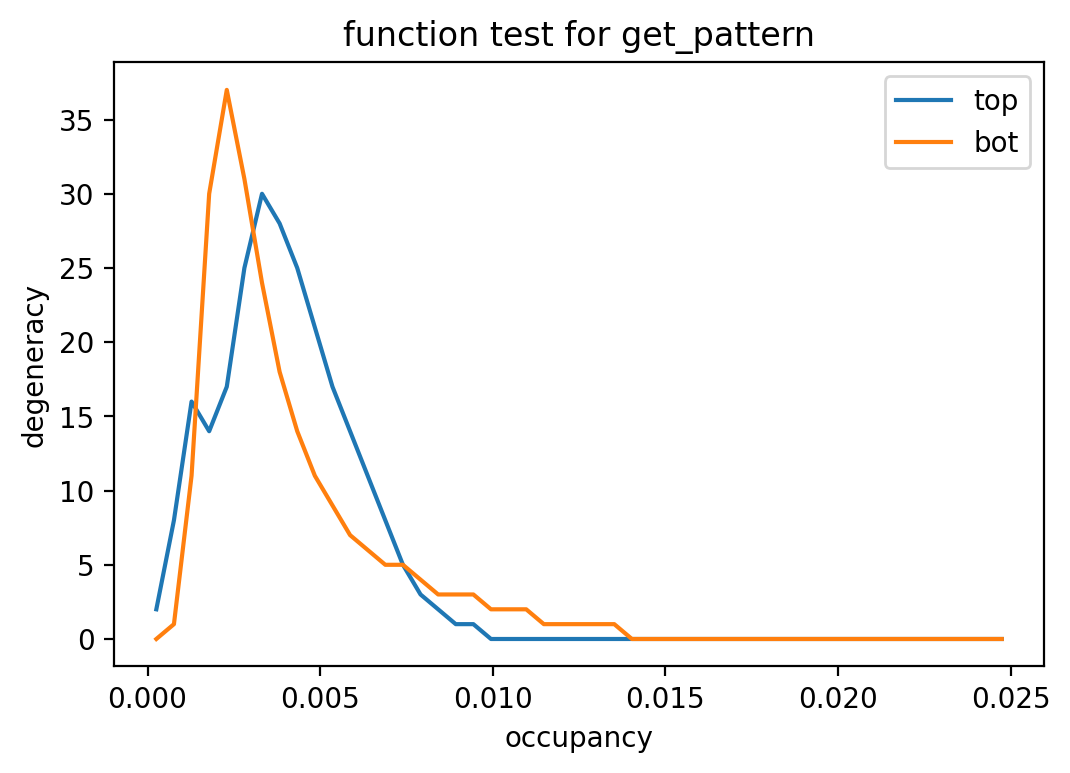

In [12]:
plt.figure(dpi=200)
occupancies, degeneracies = s1pattern.get_pattern(z_range_fv[0:2], True)
plt.plot(occupancies, degeneracies, label='top')
occupancies, degeneracies = s1pattern.get_pattern(z_range_fv[0:2], False)
plt.plot(occupancies, degeneracies, label='bot')
plt.xlabel('occupancy')
plt.ylabel('degeneracy')
plt.legend()
plt.title('function test for get_pattern')

# Check `combpile` functions

Text(0.5, 1.0, 'Pile-up and tag-along probability in one channel')

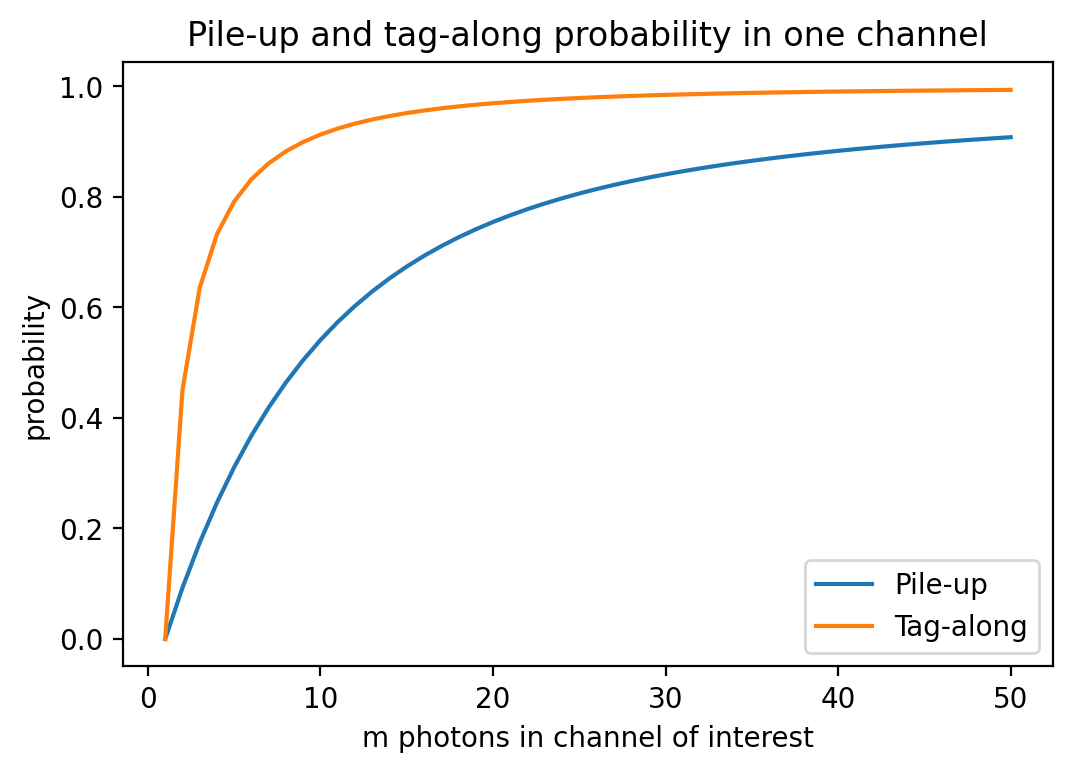

In [13]:
plt.figure(dpi=200)
p_pile_ms = []
p_tag_ms = []
max_m=50
for m in range(max_m):
    p_pile_ms.append(combpile.P_pile_m(m+1))
    p_tag_ms.append(combpile.P_tag_m(m+1))
plt.plot(np.arange(max_m)+1, p_pile_ms,label='Pile-up')
plt.plot(np.arange(max_m)+1, p_tag_ms,label='Tag-along')
plt.xlabel('m photons in channel of interest')
plt.legend()
plt.ylabel('probability')
plt.title('Pile-up and tag-along probability in one channel')

In [8]:
afts = []
z_slices = []
for i in range(10):
    indices = (15,15,12+8*i) # just convered FV
    #print('x: ', xs[indices[0]], 'y: ', ys[indices[1]], 'z: ', zs[indices[2]])
    aft = s1_pattern_map.data['map'][indices[0],indices[1],indices[2],:253].sum()/s1_pattern_map.data['map'][indices[0],indices[1],indices[2],:].sum()
    #straxen.plot_pmts(norm*s1_pattern_map.data['map'][indices[0],indices[1],indices[2],:])
    afts.append(aft)
    z = zs[indices[2]]
    z_slices.append(z)

In [9]:
n_phds = np.load('/home/yuanlq/xenon/combpile/maps/phd_pile_up_prob_x.npy')
mcs1pattern_phd_pile_up_prob_bot = np.load('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_pile_up_prob_bot.npy')
mcs1pattern_phd_pile_up_prob_top = np.load('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_pile_up_prob_top.npy')
mcs1pattern_phd_tag_along_prob_bot = np.load('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_tag_along_prob_bot.npy')
mcs1pattern_phd_tag_along_prob_top = np.load('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_tag_along_prob_top.npy')

In [10]:
"""
n_phds = np.load('/home/yuanlq/xenon/combpile/maps/phd_pile_up_prob_x.npy')
mcs1pattern_phd_pile_up_prob_bot = np.zeros((10, len(n_phds)))
mcs1pattern_phd_pile_up_prob_top = np.zeros((10, len(n_phds)))
mcs1pattern_phd_tag_along_prob_bot = np.zeros((10, len(n_phds)))
mcs1pattern_phd_tag_along_prob_top = np.zeros((10, len(n_phds)))
for i in range(10):
    mcs1pattern_phd_pile_up_prob_bot[i] = np.load('/home/yuanlq/xenon/combpile/maps/phd_pile_up_frac_bot_z%s.npy'%(i))
    mcs1pattern_phd_pile_up_prob_top[i] = np.load('/home/yuanlq/xenon/combpile/maps/phd_pile_up_frac_top_z%s.npy'%(i))
    mcs1pattern_phd_tag_along_prob_bot[i] = np.load('/home/yuanlq/xenon/combpile/maps/phd_tag_along_frac_bot_z%s.npy'%(i))
    mcs1pattern_phd_tag_along_prob_top[i] = np.load('/home/yuanlq/xenon/combpile/maps/phd_tag_along_frac_top_z%s.npy'%(i))
    
np.save('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_pile_up_prob_bot.npy', mcs1pattern_phd_pile_up_prob_bot)
np.save('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_pile_up_prob_top.npy', mcs1pattern_phd_pile_up_prob_top)
np.save('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_tag_along_prob_bot.npy', mcs1pattern_phd_tag_along_prob_bot)
np.save('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_tag_along_prob_top.npy', mcs1pattern_phd_tag_along_prob_top)
"""

"\nn_phds = np.load('/home/yuanlq/xenon/combpile/maps/phd_pile_up_prob_x.npy')\nmcs1pattern_phd_pile_up_prob_bot = np.zeros((10, len(n_phds)))\nmcs1pattern_phd_pile_up_prob_top = np.zeros((10, len(n_phds)))\nmcs1pattern_phd_tag_along_prob_bot = np.zeros((10, len(n_phds)))\nmcs1pattern_phd_tag_along_prob_top = np.zeros((10, len(n_phds)))\nfor i in range(10):\n    mcs1pattern_phd_pile_up_prob_bot[i] = np.load('/home/yuanlq/xenon/combpile/maps/phd_pile_up_frac_bot_z%s.npy'%(i))\n    mcs1pattern_phd_pile_up_prob_top[i] = np.load('/home/yuanlq/xenon/combpile/maps/phd_pile_up_frac_top_z%s.npy'%(i))\n    mcs1pattern_phd_tag_along_prob_bot[i] = np.load('/home/yuanlq/xenon/combpile/maps/phd_tag_along_frac_bot_z%s.npy'%(i))\n    mcs1pattern_phd_tag_along_prob_top[i] = np.load('/home/yuanlq/xenon/combpile/maps/phd_tag_along_frac_top_z%s.npy'%(i))\n    \nnp.save('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_pile_up_prob_bot.npy', mcs1pattern_phd_pile_up_prob_bot)\nnp.save('/home/yuanlq/xenon/c

Text(0.5, 1.0, 'Pile-up fraction in different depth; darker=deeper')

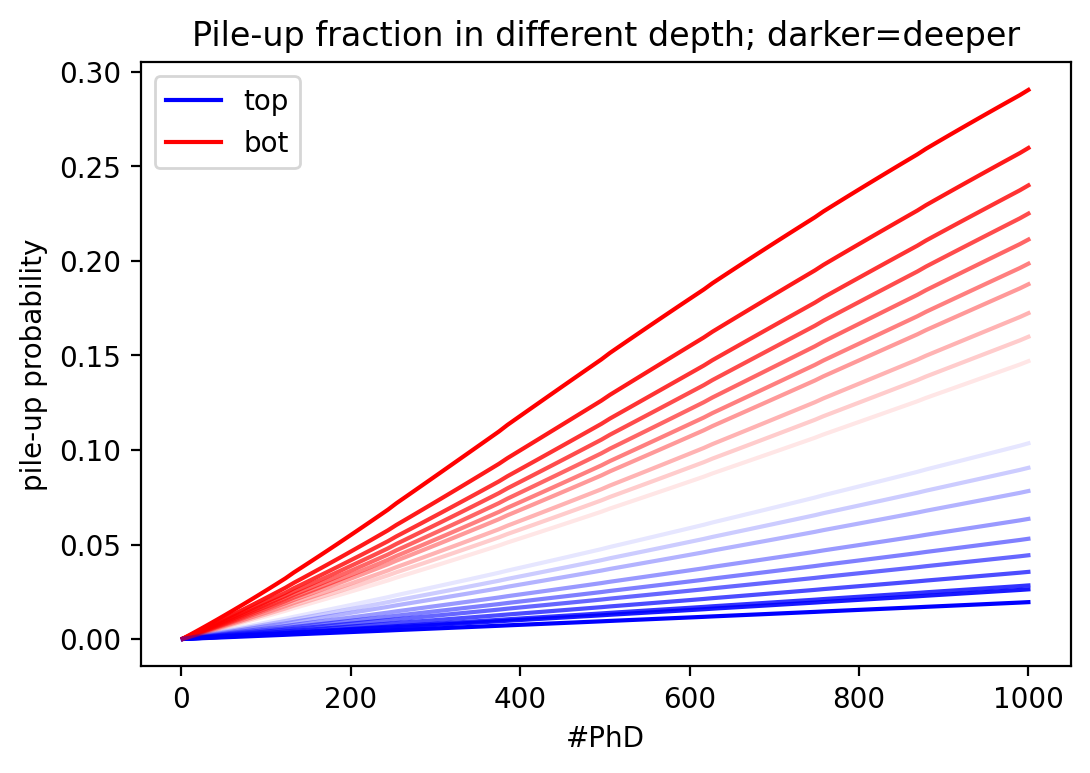

In [11]:
plt.figure(dpi=200)
for i in range(10):
    if i == 0:
        plt.plot(n_phds,mcs1pattern_phd_pile_up_prob_top[i,:], color='b', label='top')
        plt.plot(n_phds,mcs1pattern_phd_pile_up_prob_bot[i,:], color='r', label='bot')
    else:
        plt.plot(n_phds,mcs1pattern_phd_pile_up_prob_top[i,:], color='b', alpha=1-0.1*i)
        plt.plot(n_phds,mcs1pattern_phd_pile_up_prob_bot[i,:], color='r', alpha=1-0.1*i)

plt.xlabel('#PhD')
plt.legend()
plt.ylabel('pile-up probability')
plt.title('Pile-up fraction in different depth; darker=deeper')

Text(0.5, 1.0, 'Tag-along fraction in different depth; darker=deeper')

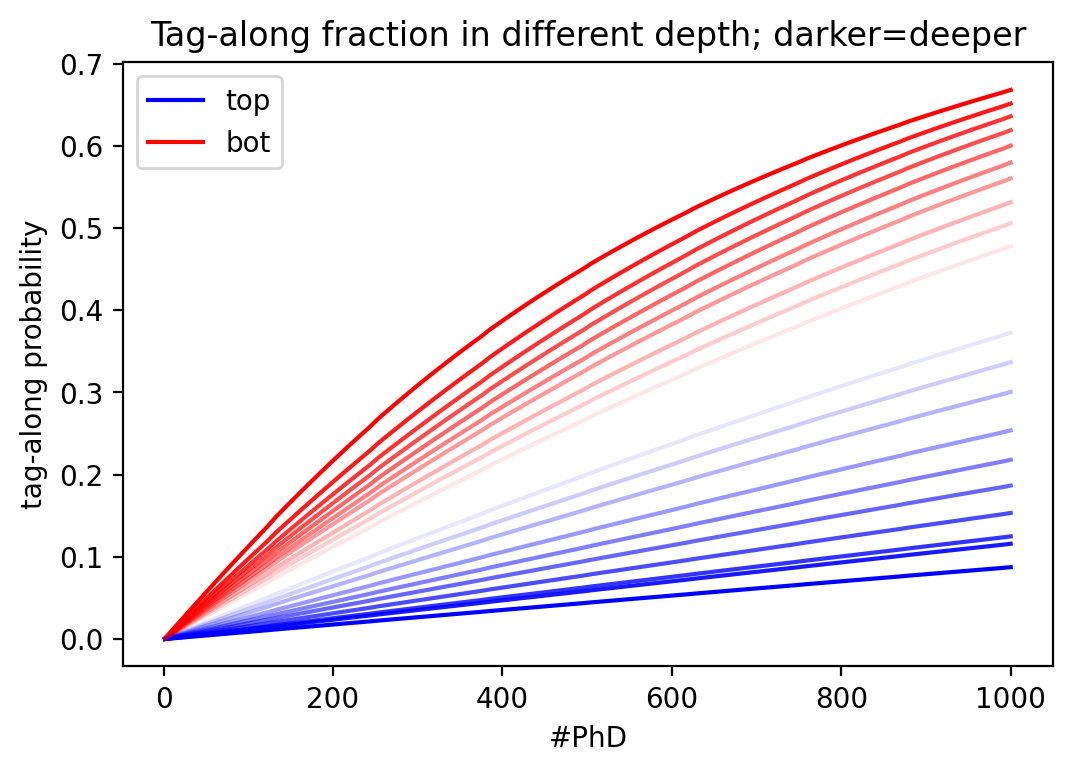

In [12]:
plt.figure(dpi=200)
for i in range(10):
    if i == 0:
        plt.plot(n_phds,mcs1pattern_phd_tag_along_prob_top[i,:], color='b', label='top')
        plt.plot(n_phds,mcs1pattern_phd_tag_along_prob_bot[i,:], color='r', label='bot')
    else:
        plt.plot(n_phds,mcs1pattern_phd_tag_along_prob_top[i,:], color='b', alpha=1-0.1*i)
        plt.plot(n_phds,mcs1pattern_phd_tag_along_prob_bot[i,:], color='r', alpha=1-0.1*i)

plt.xlabel('#PhD')
plt.legend()
plt.ylabel('tag-along probability')
plt.title('Tag-along fraction in different depth; darker=deeper')

# PhD acceptance

In [19]:
spe_amps_indices, spe_amps_top = spectrums.get_avg_spe_amp(True, trunc_bound=None)
spe_amps_indices, spe_amps_bot = spectrums.get_avg_spe_amp(False, trunc_bound=None)

top mean:  40.84554195840197 ADC
bot mean:  39.857835506146436 ADC


Text(0.5, 1.0, 'SPE amplitude spectrum from LED calibration')

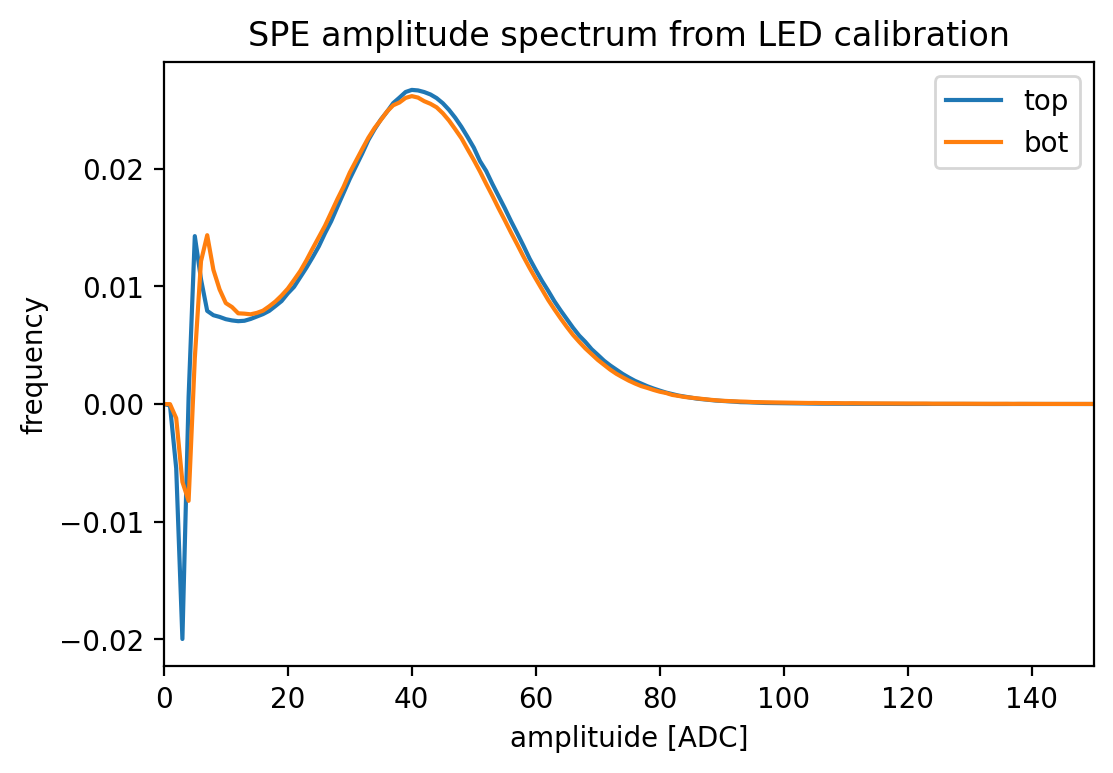

In [20]:
plt.figure(dpi=200)
plt.plot(spe_amps_indices, spe_amps_top, label='top')
plt.plot(spe_amps_indices, spe_amps_bot, label='bot')
plt.xlabel('amplituide [ADC]')
plt.ylabel('frequency')
plt.legend()
plt.xlim(0,150)
print('top mean: ', np.sum(spe_amps_indices * spe_amps_top), 'ADC')
print('bot mean: ', np.sum(spe_amps_indices * spe_amps_bot), 'ADC')
plt.title('SPE amplitude spectrum from LED calibration')

In [21]:
dpe_amps_indices, dpe_amps_top = spectrums.get_avg_dpe_amp(True)
dpe_amps_indices, dpe_amps_bot = spectrums.get_avg_dpe_amp(False)

Text(0.5, 1.0, 'SPE-self-convoluted DPE amplitude spectrum from LED calibration')

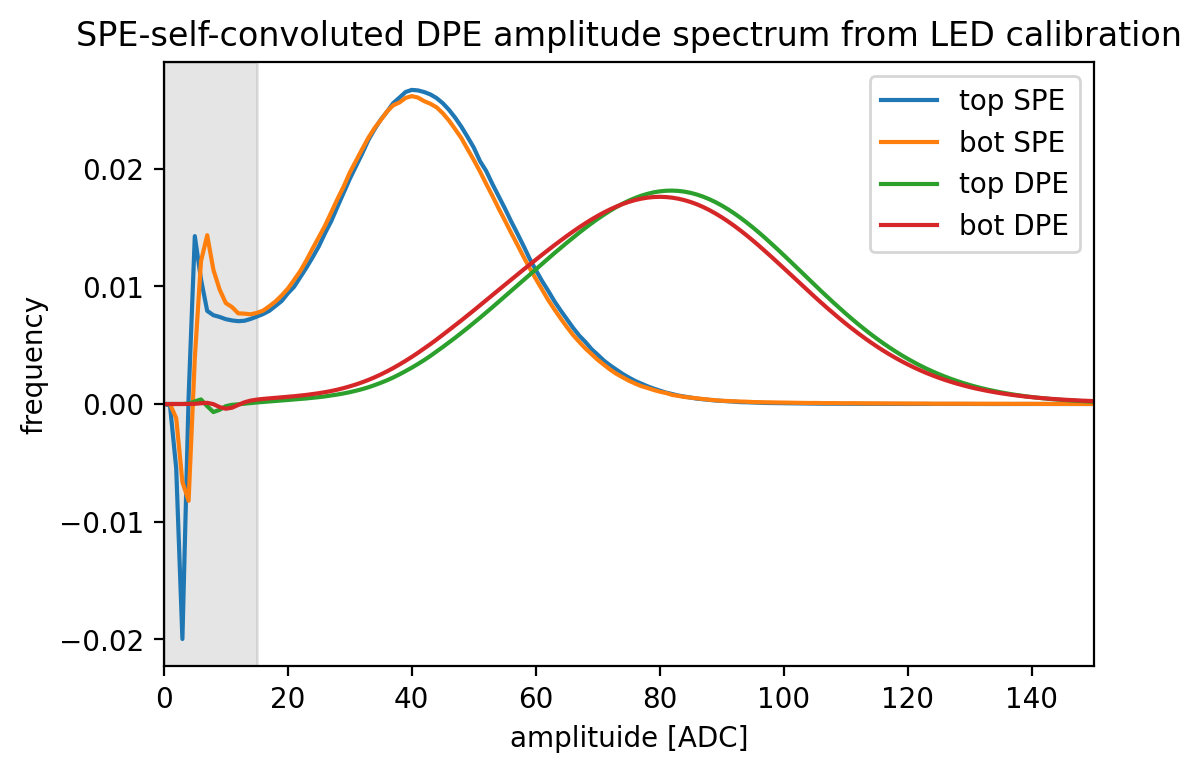

In [22]:
plt.figure(dpi=200)
plt.plot(spe_amps_indices, spe_amps_top, label='top SPE')
plt.plot(spe_amps_indices, spe_amps_bot, label='bot SPE')
plt.plot(dpe_amps_indices, dpe_amps_top, label='top DPE')
plt.plot(dpe_amps_indices, dpe_amps_bot, label='bot DPE')
plt.xlabel('amplituide [ADC]')
plt.ylabel('frequency')
plt.xlim(0,150)
plt.legend()
plt.axvspan(0,15,label='DAQ loss', color='k', alpha=0.1)

plt.title('SPE-self-convoluted DPE amplitude spectrum from LED calibration')

In [23]:
sphd_amps_indices, sphd_amps_top = spectrums.get_avg_sphd_amp(True)
sphd_amps_indices, sphd_amps_bot = spectrums.get_avg_sphd_amp(False)

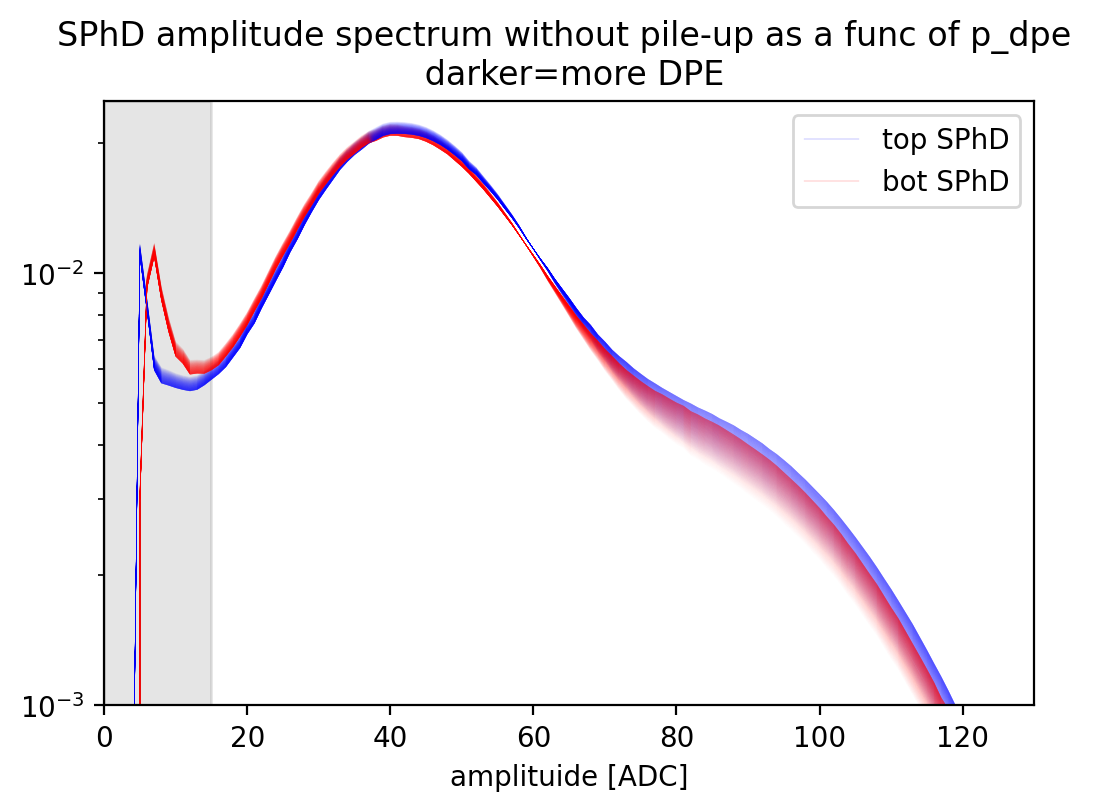

In [24]:
plt.figure(dpi=200)
for i in range(100):
    if i== 99:
        plt.plot(sphd_amps_indices, sphd_amps_top[i], label='top SPhD', alpha=0.01+0.008*i, color='b',linewidth=0.1)
        plt.plot(sphd_amps_indices, sphd_amps_bot[i], label='bot SPhD', alpha=0.01+0.008*i, color='r',linewidth=0.1)
    
    else:
        plt.plot(sphd_amps_indices, sphd_amps_top[i], alpha=0.01+0.008*i, color='b',linewidth=0.1)
        plt.plot(sphd_amps_indices, sphd_amps_bot[i], alpha=0.01+0.008*i, color='r',linewidth=0.1)

plt.xlabel('amplituide [ADC]')
plt.title('SPhD amplitude spectrum without pile-up as a func of p_dpe \n darker=more DPE')
plt.xlim(0,130)
plt.ylim(0.001,0.025)
plt.yscale('log')
plt.legend()
plt.axvspan(0,15,label='DAQ loss', color='k', alpha=0.1)

In [25]:
dphd_amps_indices, dphd_amps_top = spectrums.get_avg_dphd_amp(True)
dphd_amps_indices, dphd_amps_bot = spectrums.get_avg_dphd_amp(False)

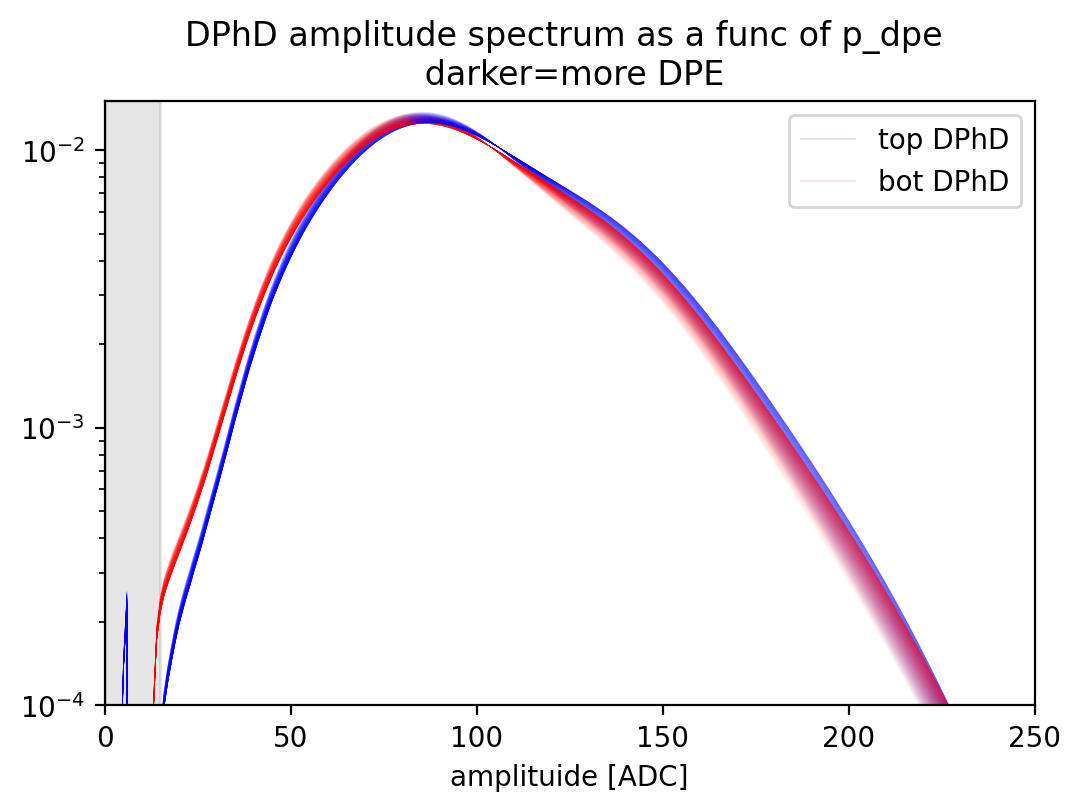

In [26]:
plt.figure(dpi=200)
for i in range(100):
    if i== 99:
        plt.plot(dphd_amps_indices, dphd_amps_top[i], label='top DPhD', alpha=0.01+0.008*i, color='b',linewidth=0.1)
        plt.plot(dphd_amps_indices, dphd_amps_bot[i], label='bot DPhD', alpha=0.01+0.008*i, color='r',linewidth=0.1)
    
    else:
        plt.plot(dphd_amps_indices, dphd_amps_top[i], alpha=0.01+0.008*i, color='b',linewidth=0.1)
        plt.plot(dphd_amps_indices, dphd_amps_bot[i], alpha=0.01+0.008*i, color='r',linewidth=0.1)        

plt.xlabel('amplituide [ADC]')
plt.title('DPhD amplitude spectrum as a func of p_dpe \n darker=more DPE')
plt.xlim(0,250)
plt.ylim(0.0001,0.015)
plt.yscale('log')
plt.legend()
plt.axvspan(0,15,label='DAQ loss', color='k', alpha=0.1)

In [24]:
np.sum(dphd_amps_top[:,:np.where(dphd_amps_indices==15)[0][0]+1], axis=1)

array([-0.00050577, -0.000505  , -0.00050424, -0.00050348, -0.00050272,
       -0.00050196, -0.0005012 , -0.00050044, -0.00049968, -0.00049892,
       -0.00049816, -0.0004974 , -0.00049664, -0.00049589, -0.00049513,
       -0.00049437, -0.00049362, -0.00049287, -0.00049211, -0.00049136,
       -0.00049061, -0.00048985, -0.0004891 , -0.00048835, -0.0004876 ,
       -0.00048685, -0.0004861 , -0.00048535, -0.00048461, -0.00048386,
       -0.00048311, -0.00048237, -0.00048162, -0.00048087, -0.00048013,
       -0.00047939, -0.00047864, -0.0004779 , -0.00047716, -0.00047642,
       -0.00047567, -0.00047493, -0.00047419, -0.00047345, -0.00047272,
       -0.00047198, -0.00047124, -0.0004705 , -0.00046977, -0.00046903,
       -0.0004683 , -0.00046756, -0.00046683, -0.00046609, -0.00046536,
       -0.00046463, -0.0004639 , -0.00046316, -0.00046243, -0.0004617 ,
       -0.00046097, -0.00046025, -0.00045952, -0.00045879, -0.00045806,
       -0.00045734, -0.00045661, -0.00045588, -0.00045516, -0.00

In [25]:
np.sum(dphd_amps_bot[:,:np.where(dphd_amps_indices==15)[0][0]+1], axis=1)

array([-4.59674132e-05, -4.58795945e-05, -4.57918555e-05, -4.57041961e-05,
       -4.56166164e-05, -4.55291164e-05, -4.54416960e-05, -4.53543554e-05,
       -4.52670944e-05, -4.51799131e-05, -4.50928114e-05, -4.50057895e-05,
       -4.49188472e-05, -4.48319846e-05, -4.47452017e-05, -4.46584985e-05,
       -4.45718749e-05, -4.44853311e-05, -4.43988669e-05, -4.43124823e-05,
       -4.42261775e-05, -4.41399523e-05, -4.40538068e-05, -4.39677410e-05,
       -4.38817549e-05, -4.37958485e-05, -4.37100217e-05, -4.36242746e-05,
       -4.35386072e-05, -4.34530195e-05, -4.33675114e-05, -4.32820830e-05,
       -4.31967343e-05, -4.31114653e-05, -4.30262760e-05, -4.29411663e-05,
       -4.28561363e-05, -4.27711860e-05, -4.26863154e-05, -4.26015245e-05,
       -4.25168132e-05, -4.24321816e-05, -4.23476297e-05, -4.22631575e-05,
       -4.21787649e-05, -4.20944520e-05, -4.20102188e-05, -4.19260653e-05,
       -4.18419915e-05, -4.17579973e-05, -4.16740828e-05, -4.15902480e-05,
       -4.15064929e-05, -

When DPhD happens, the average acceptance is > 99.95%

In [3]:
dpes, pile_probs, tag_probs, avg_phd_acc_top = spectrums.get_avg_phd_acc(True)
dpes, pile_probs, tag_probs, avg_phd_acc_bot = spectrums.get_avg_phd_acc(False)

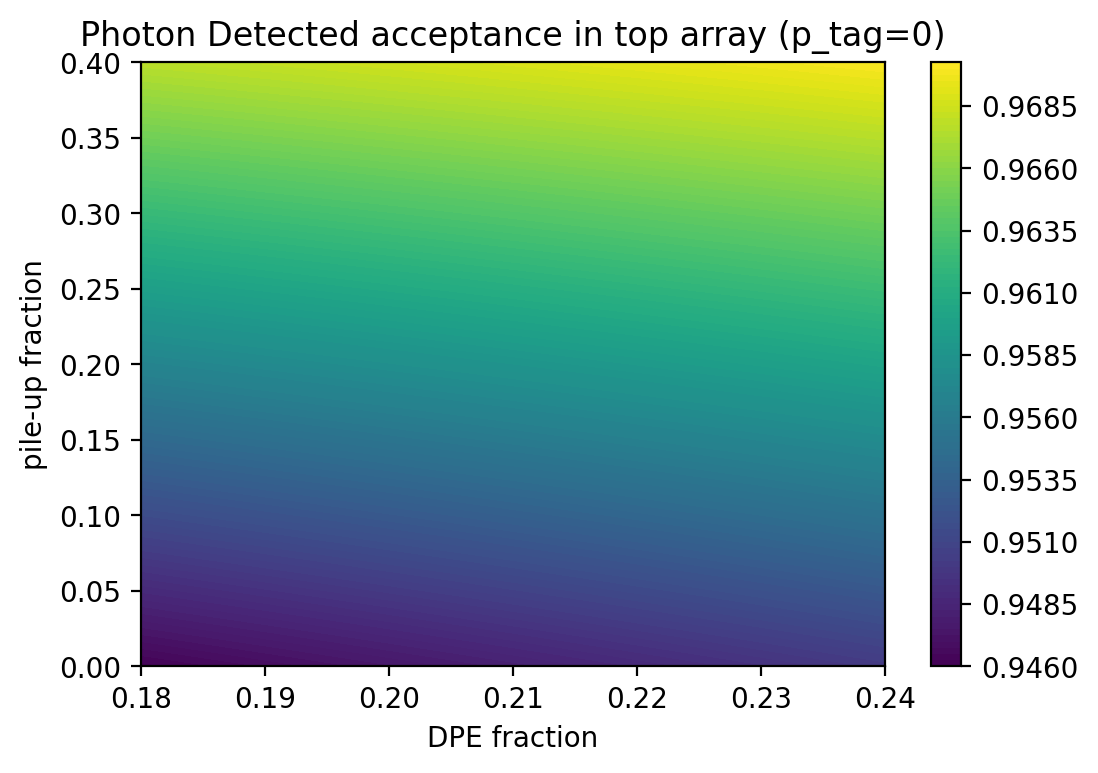

In [4]:
plt.figure(dpi=200)
x,y = np.meshgrid(dpes, pile_probs)
plt.contourf(x, y, avg_phd_acc_top[:,:,0].transpose(),levels=100)
plt.xlabel('DPE fraction')
plt.ylabel('pile-up fraction')
plt.title('Photon Detected acceptance in top array (p_tag=0)')
plt.colorbar()

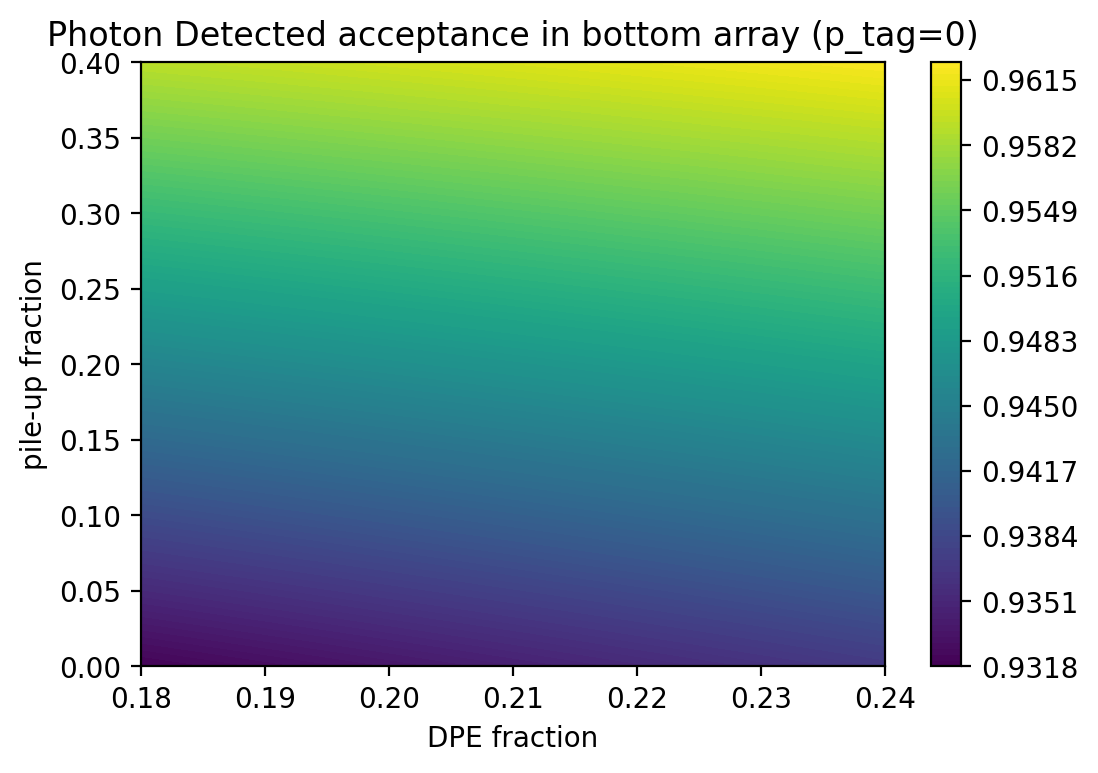

In [5]:
plt.figure(dpi=200)
x,y = np.meshgrid(dpes, pile_probs)
plt.contourf(x, y, avg_phd_acc_bot[:,:,0].transpose(),levels=100)
plt.xlabel('DPE fraction')
plt.ylabel('pile-up fraction')
plt.title('Photon Detected acceptance in bottom array (p_tag=0)')
plt.colorbar()

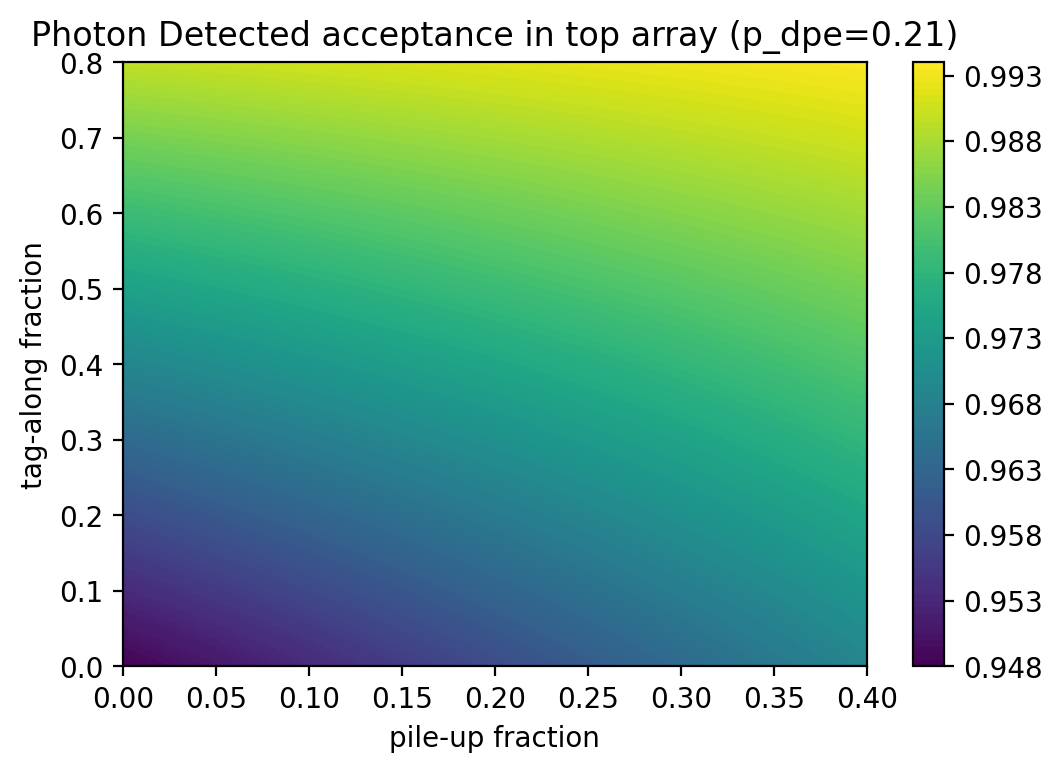

In [6]:
plt.figure(dpi=200)
x,y = np.meshgrid(pile_probs, tag_probs)
plt.contourf(x, y, avg_phd_acc_top[50,:,:].transpose(),levels=100)
plt.xlabel('pile-up fraction')
plt.ylabel('tag-along fraction')
plt.title('Photon Detected acceptance in top array (p_dpe=0.21)')
plt.colorbar()

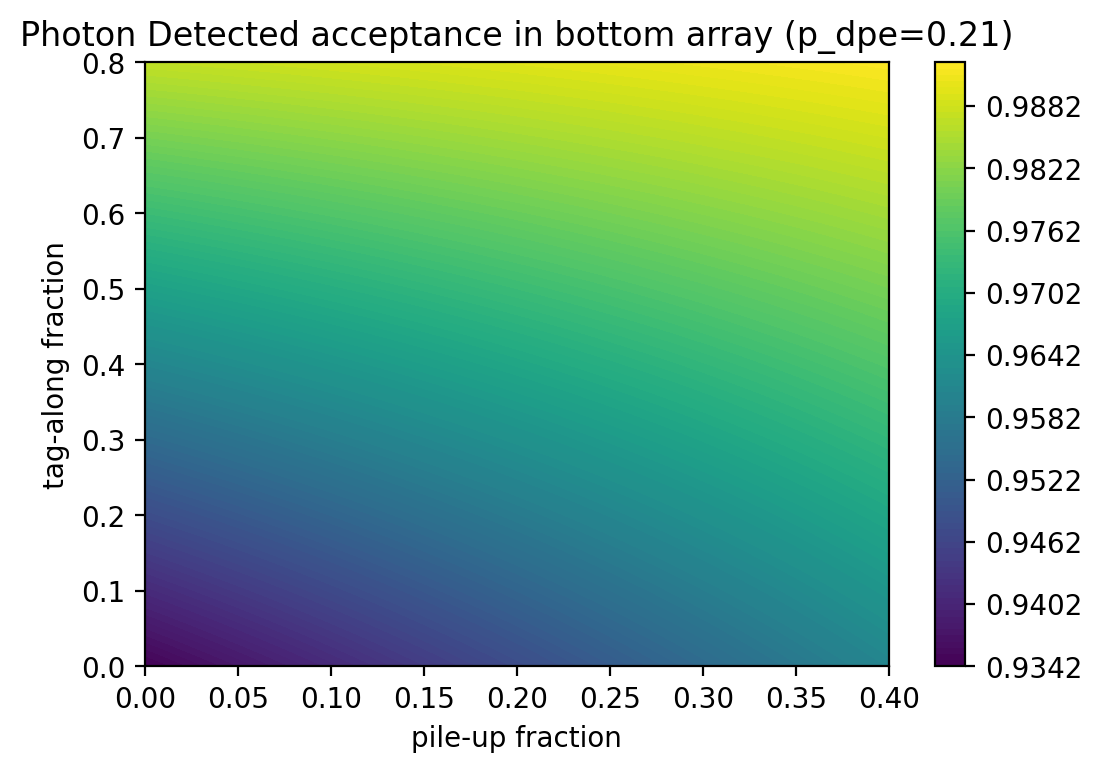

In [7]:
plt.figure(dpi=200)
x,y = np.meshgrid(pile_probs, tag_probs)
plt.contourf(x, y, avg_phd_acc_bot[50,:,:].transpose(),levels=100)
plt.xlabel('pile-up fraction')
plt.ylabel('tag-along fraction')
plt.title('Photon Detected acceptance in bottom array (p_dpe=0.21)')
plt.colorbar()

We can in fact build the acceptance as a function of $z$ and $p_{\text{dpe}}$

In [9]:
n_phds = np.load('/home/yuanlq/xenon/combpile/maps/phd_pile_up_prob_x.npy')
mcs1pattern_phd_pile_up_prob_bot = np.load('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_pile_up_prob_bot.npy')
mcs1pattern_phd_pile_up_prob_top = np.load('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_pile_up_prob_top.npy')
mcs1pattern_phd_tag_along_prob_bot = np.load('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_tag_along_prob_bot.npy')
mcs1pattern_phd_tag_along_prob_top = np.load('/home/yuanlq/xenon/combpile/maps/mcs1pattern_phd_tag_along_prob_top.npy')

In [14]:
# axis0 = z, axis1 = nphd, axis2 = dpe
avg_phd_acc_top_zdpe = np.zeros((10,100,100))
avg_phd_acc_bot_zdpe = np.zeros((10,100,100))

for z in tqdm(range(10)):
    for n in range(100):
        pile_bot = mcs1pattern_phd_pile_up_prob_bot[z,n]
        pile_top = mcs1pattern_phd_pile_up_prob_top[z, n]
        tag_bot = mcs1pattern_phd_tag_along_prob_bot[z, n]
        tag_top = mcs1pattern_phd_tag_along_prob_top[z, n]
        
        _,_,_,acc_top = spectrums.get_avg_phd_acc(True, pile_probs=pile_top, tag_probs=tag_top)
        _,_,_,acc_bot = spectrums.get_avg_phd_acc(False, pile_probs=pile_bot, tag_probs=tag_bot)
        
        avg_phd_acc_top_zdpe[z,n,:] = acc_top.reshape(100)
        avg_phd_acc_bot_zdpe[z,n,:] = acc_bot.reshape(100)
        

100%|██████████| 10/10 [09:56<00:00, 59.63s/it]


Text(0.5, 1.0, 'Single Photno acceptance in different depth \n darker=deeper; p_dpe=0.21')

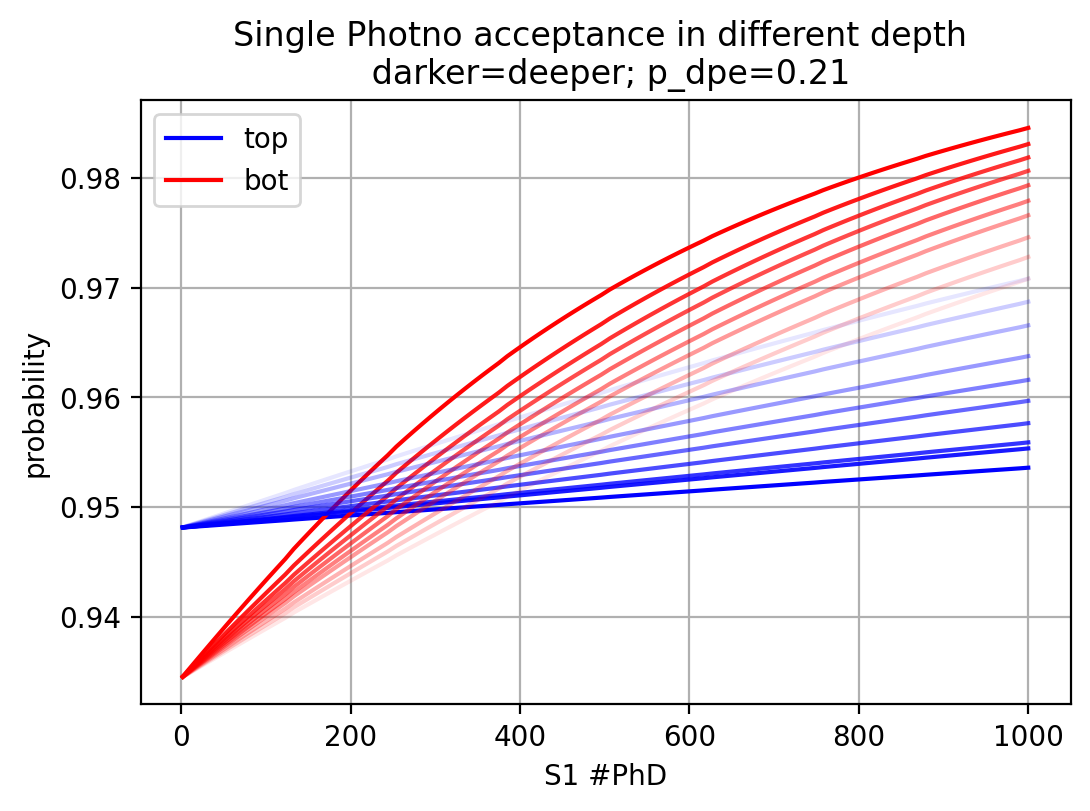

In [36]:
plt.figure(dpi=200)
plt.grid()
for z in range(10):
    if z == 0:
        plt.plot(n_phds, avg_phd_acc_top_zdpe[z,:,50], color='b', label='top')
        plt.plot(n_phds,avg_phd_acc_bot_zdpe[z,:,50], color='r', label='bot')
    else:
        plt.plot(n_phds,avg_phd_acc_top_zdpe[z,:,50], color='b', alpha=1-0.1*z)
        plt.plot(n_phds,avg_phd_acc_bot_zdpe[z,:,50], color='r', alpha=1-0.1*z)
    
plt.xlabel('S1 #PhD')
plt.legend()
plt.ylabel('probability')
plt.title('Single Photno acceptance in different depth \n darker=deeper; p_dpe=0.21')

In [11]:
"""
np.save('/home/yuanlq/xenon/combpile/maps/avg_phd_acc_dpes.npy', dpes)
np.save('/home/yuanlq/xenon/combpile/maps/avg_phd_acc_pile_probs.npy', pile_probs)
np.save('/home/yuanlq/xenon/combpile/maps/avg_phd_acc_tag_probs.npy', tag_probs)
np.save('/home/yuanlq/xenon/combpile/maps/avg_phd_acc_top.npy', avg_phd_acc_top)
np.save('/home/yuanlq/xenon/combpile/maps/avg_phd_acc_bot.npy', avg_phd_acc_bot)
"""

# PhR spectrum

In [3]:
spe_areas_indices, spe_areas_top = spectrums.get_avg_spe_area(True)
spe_areas_indices, spe_areas_bot = spectrums.get_avg_spe_area(False)

top mean:  1.0276098675190524 PE
bot mean:  1.0178168619946204 PE


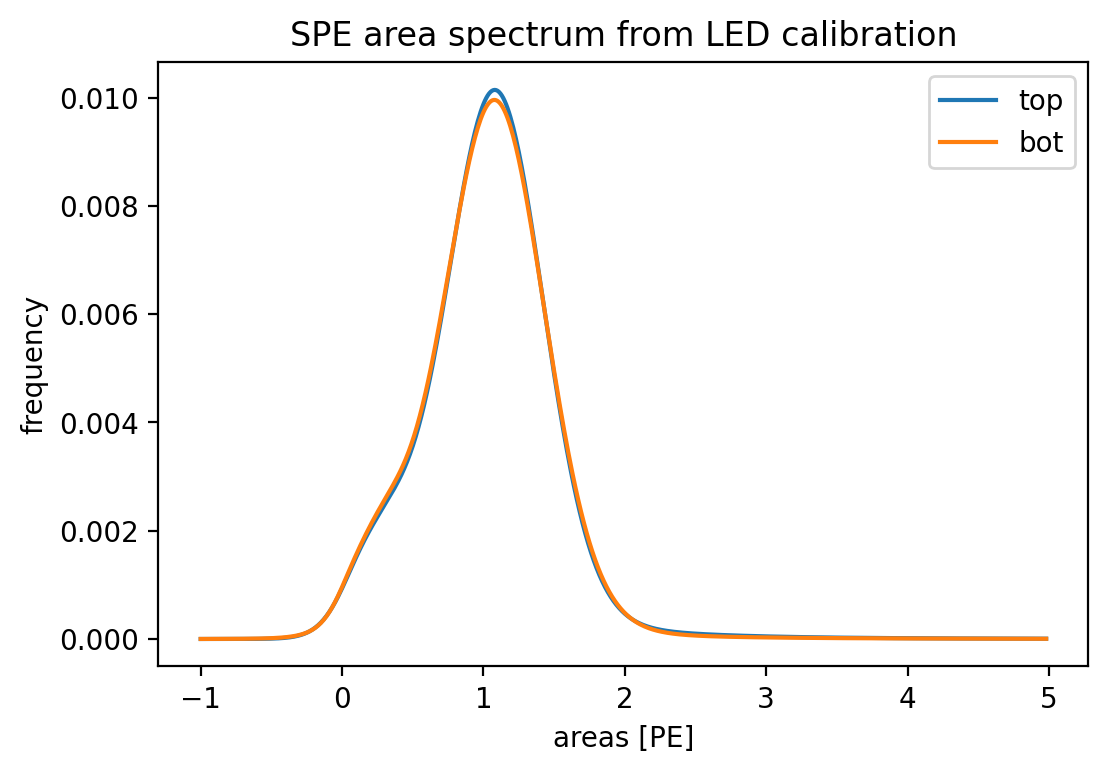

In [32]:
plt.figure(dpi=200)
plt.plot(spe_areas_indices, spe_areas_top, label='top')
plt.plot(spe_areas_indices, spe_areas_bot, label='bot')
plt.xlabel('areas [PE]')
plt.ylabel('frequency')
plt.title('SPE area spectrum from LED calibration')
plt.legend()
print('top mean: ', np.sum(spe_areas_indices*spe_areas_top), 'PE')
print('bot mean: ', np.sum(spe_areas_indices*spe_areas_bot), 'PE')

In [33]:
dpe_areas_indices, dpe_areas_top = spectrums.get_avg_dpe_area(True)
dpe_areas_indices, dpe_areas_bot = spectrums.get_avg_dpe_area(False)

/home/yuanlq/xenon/combpile/spectrums.py:254: RuntimeWarning: invalid value encountered in true_divide
  spe_areas_norm[i] = spe_areas[i]/spe_areas[i].sum()


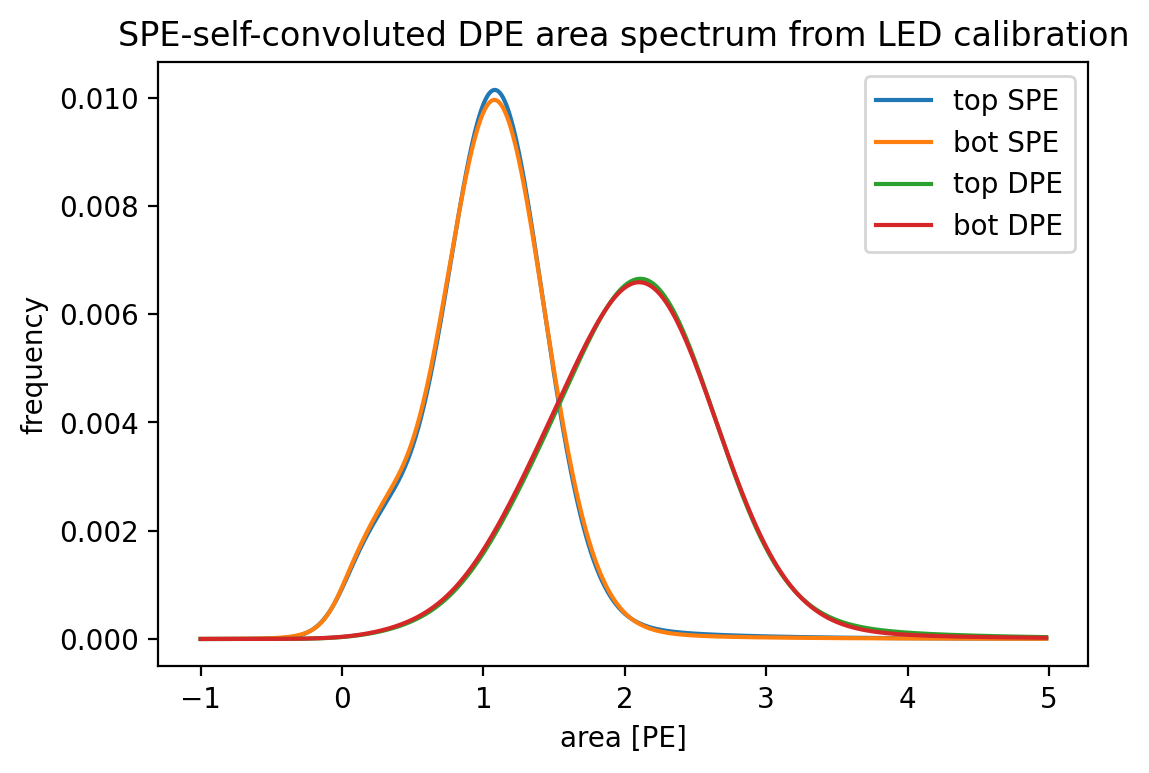

In [34]:
plt.figure(dpi=200)
plt.plot(spe_areas_indices, spe_areas_top, label='top SPE')
plt.plot(spe_areas_indices, spe_areas_bot, label='bot SPE')
plt.plot(dpe_areas_indices, dpe_areas_top, label='top DPE')
plt.plot(dpe_areas_indices, dpe_areas_bot, label='bot DPE')
plt.xlabel('area [PE]')
plt.ylabel('frequency')
plt.title('SPE-self-convoluted DPE area spectrum from LED calibration')
plt.legend()


In [5]:
sphd_areas_indices, sphd_areas_top = spectrums.get_avg_sphd_area(True)
sphd_areas_indices, sphd_areas_bot = spectrums.get_avg_sphd_area(False)

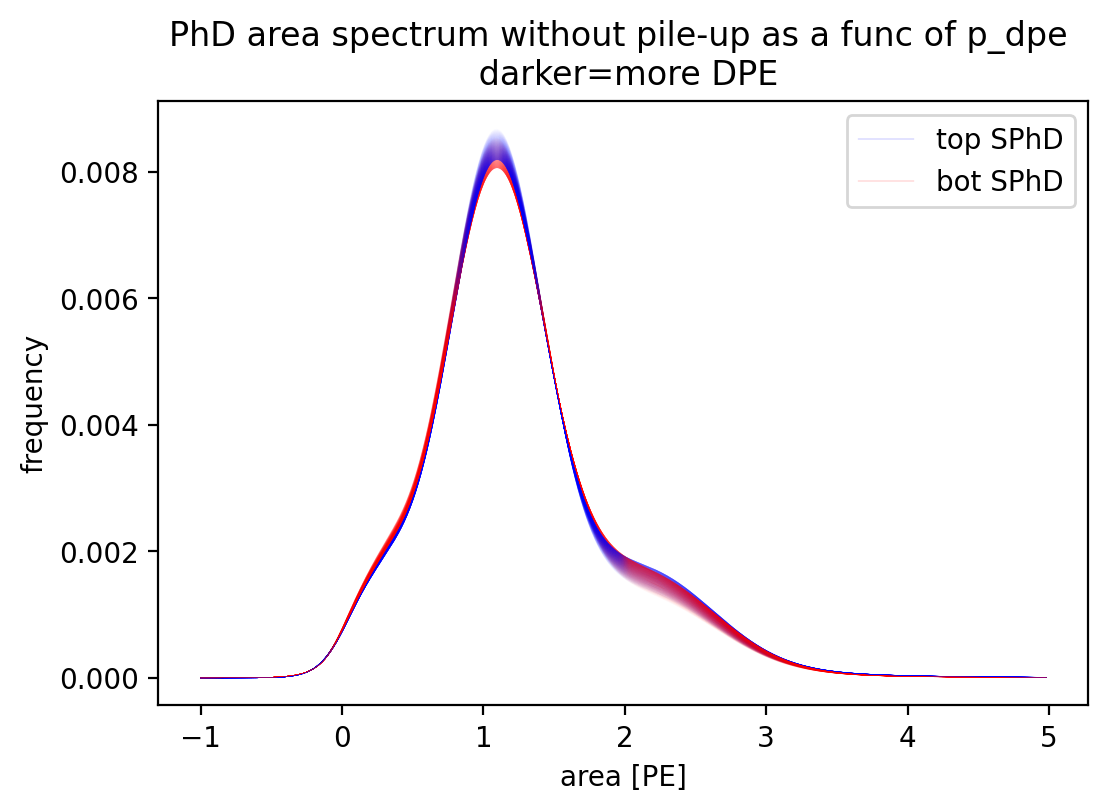

In [36]:
plt.figure(dpi=200)
for i in range(100):
    if i== 99:
        plt.plot(sphd_areas_indices, sphd_areas_top[i], label='top SPhD', alpha=0.01+0.008*i, color='b',linewidth=0.1)
        plt.plot(sphd_areas_indices, sphd_areas_bot[i], label='bot SPhD', alpha=0.01+0.008*i, color='r',linewidth=0.1)
    
    else:
        plt.plot(sphd_areas_indices, sphd_areas_top[i], alpha=0.01+0.008*i, color='b',linewidth=0.1)
        plt.plot(sphd_areas_indices, sphd_areas_bot[i], alpha=0.01+0.008*i, color='r',linewidth=0.1)

plt.xlabel('area [PE]')
plt.ylabel('frequency')
plt.title('PhD area spectrum without pile-up as a func of p_dpe \n darker=more DPE')
#plt.yscale('log')
plt.legend()

In [27]:
# Obtained from argon hit spectrum in channels who only have one hit
sphr_areas_indices, sphr_areas_top = spectrums.get_avg_sphr_area(True)
sphr_areas_indices, sphr_areas_bot = spectrums.get_avg_sphr_area(False)

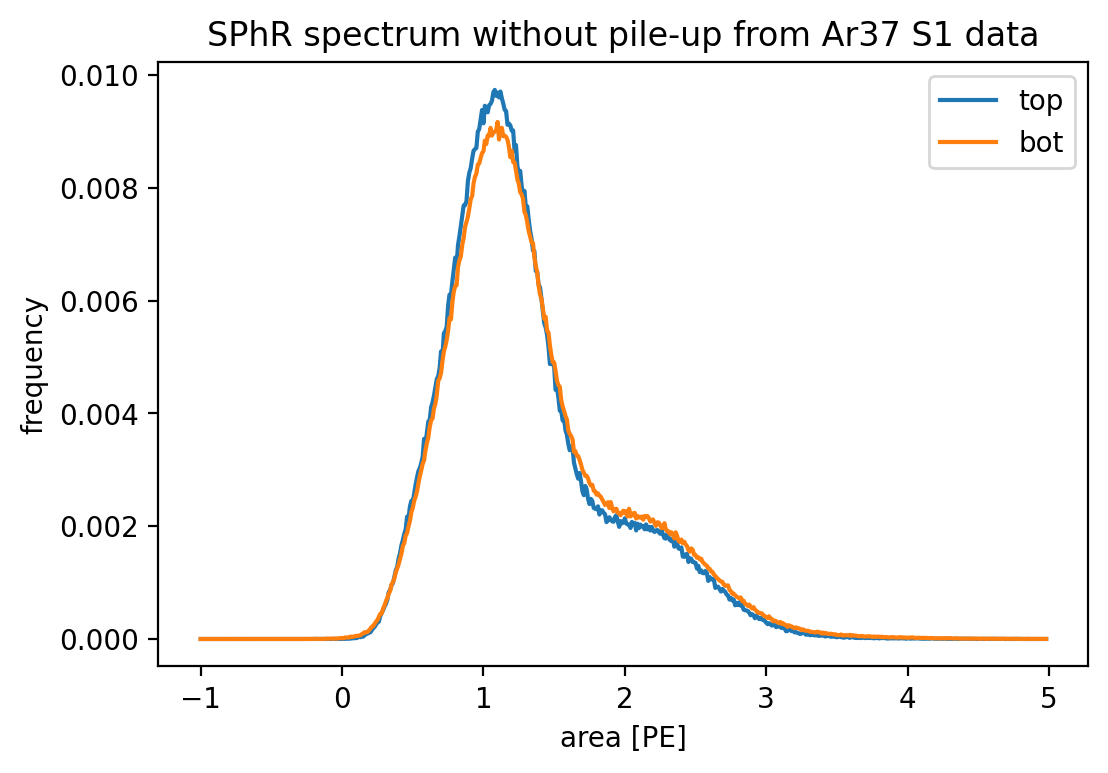

In [38]:
plt.figure(dpi=200)
plt.plot(sphr_areas_indices, sphr_areas_top, label='top')
plt.plot(sphr_areas_indices, sphr_areas_bot, label='bot')
plt.xlabel('area [PE]')
plt.ylabel('frequency')
plt.title('SPhR spectrum without pile-up from Ar37 S1 data')
plt.legend()

In [19]:
dpes, pile_probs, tag_probs, avg_phr_areas_top = spectrums.get_avg_phr_area(True)
dpes, pile_probs, tag_probs, avg_phr_areas_bot = spectrums.get_avg_phr_area(False)

/home/yuanlq/xenon/combpile/spectrums.py:252: RuntimeWarning: invalid value encountered in true_divide
  spe_areas_norm[i] = spe_areas[i]/spe_areas[i].sum()
100it [00:19,  5.01it/s]
100it [00:19,  5.04it/s]


In [11]:
np.shape(avg_phr_areas_top)

(100, 100, 100, 599)

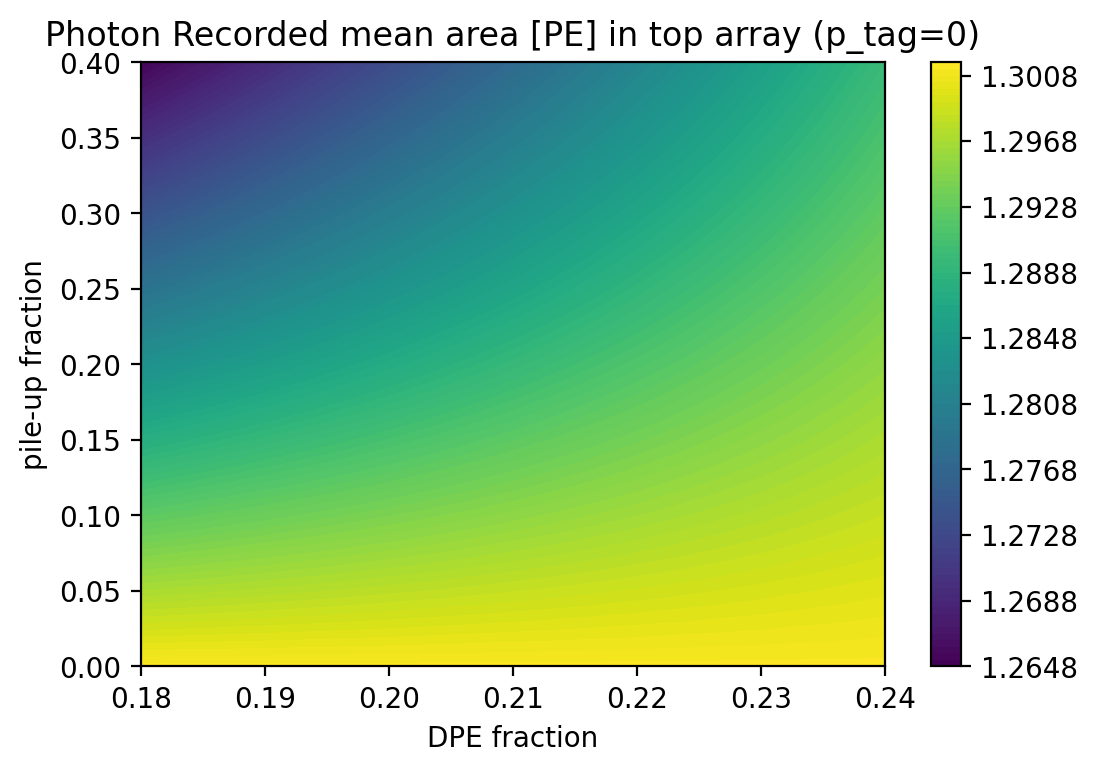

In [21]:
plt.figure(dpi=200)
x,y = np.meshgrid(dpes, pile_probs)
plt.contourf(x, y, np.sum(sphr_areas_indices*avg_phr_areas_top[:,:,0,:],axis=2).transpose(),levels=100)
plt.xlabel('DPE fraction')
plt.ylabel('pile-up fraction')
plt.title('Photon Recorded mean area [PE] in top array (p_tag=0)')
plt.colorbar()

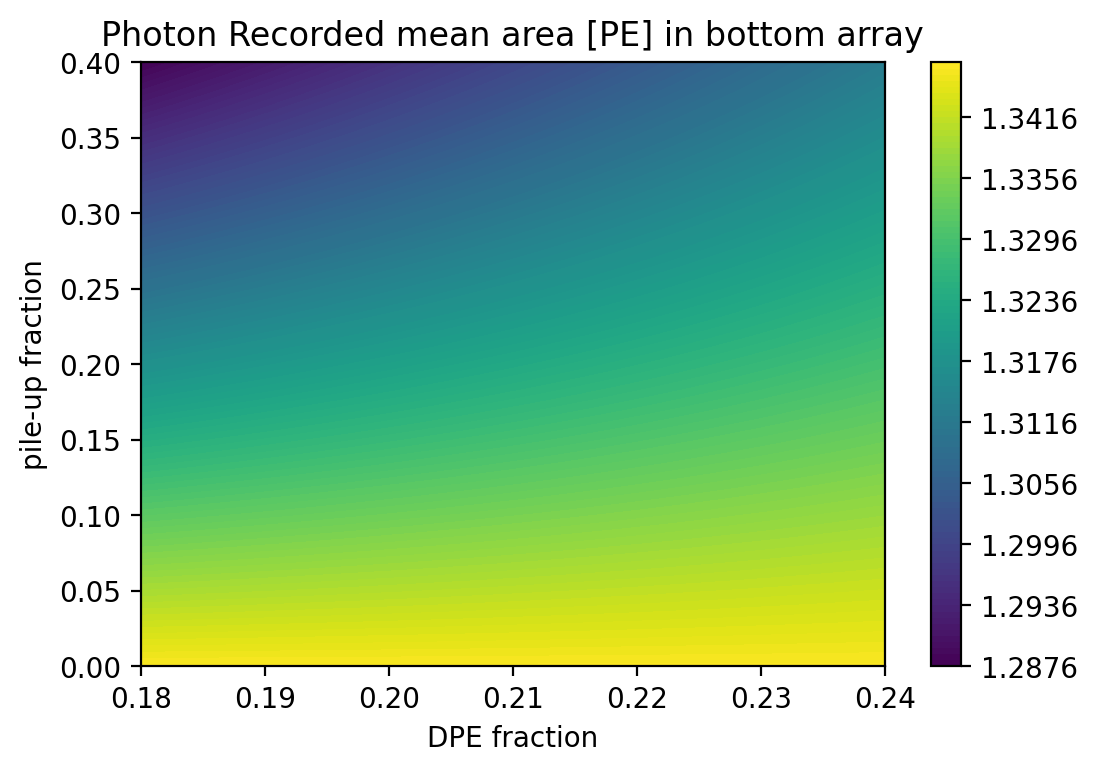

In [14]:
plt.figure(dpi=200)
x,y = np.meshgrid(dpes, pile_probs)
plt.contourf(x, y, np.sum(sphr_areas_indices*avg_phr_areas_bot[:,:,0,:],axis=2).transpose(),levels=100)
plt.xlabel('DPE fraction')
plt.ylabel('pile-up fraction')
plt.title('Photon Recorded mean area [PE] in bottom array')
plt.colorbar()

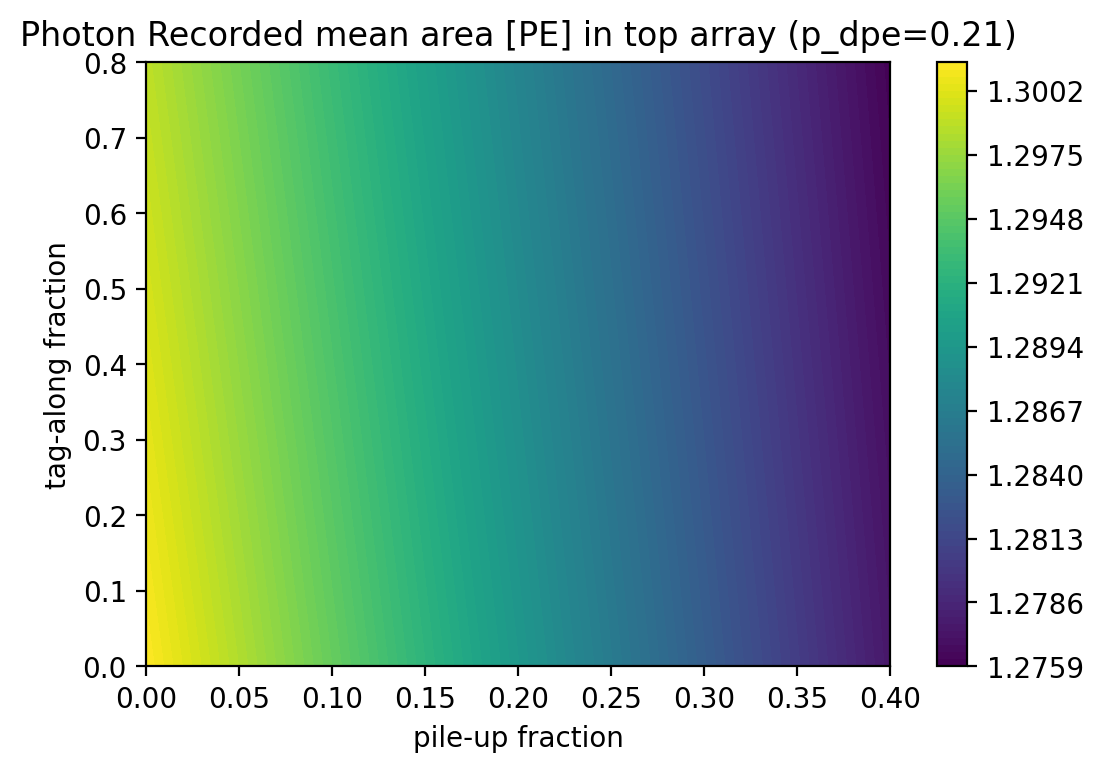

In [22]:
plt.figure(dpi=200)
x,y = np.meshgrid(pile_probs, tag_probs)
plt.contourf(x, y, np.sum(sphr_areas_indices*avg_phr_areas_top[50,:,:,:],axis=2).transpose(),levels=100)
plt.xlabel('pile-up fraction')
plt.ylabel('tag-along fraction')
plt.title('Photon Recorded mean area [PE] in top array (p_dpe=0.21)')
plt.colorbar()

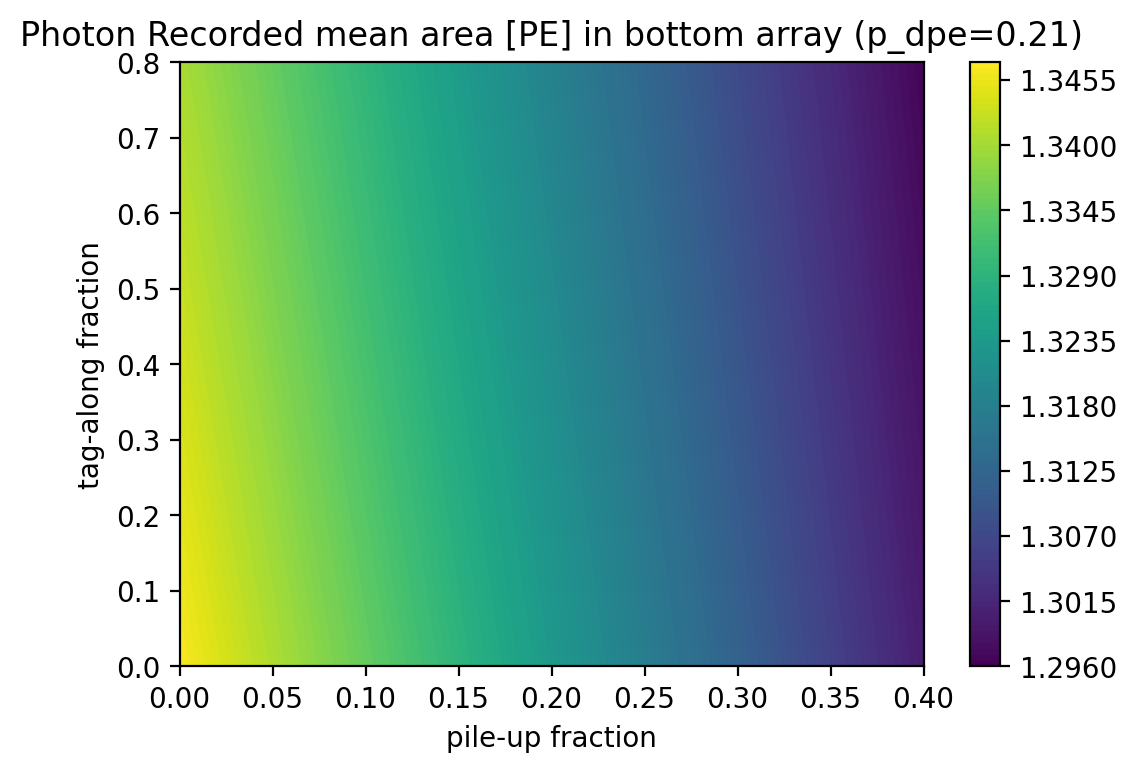

In [23]:
plt.figure(dpi=200)
x,y = np.meshgrid(pile_probs, tag_probs)
plt.contourf(x, y, np.sum(sphr_areas_indices*avg_phr_areas_bot[50,:,:,:],axis=2).transpose(),levels=100)
plt.xlabel('pile-up fraction')
plt.ylabel('tag-along fraction')
plt.title('Photon Recorded mean area [PE] in bottom array (p_dpe=0.21)')
plt.colorbar()

In [25]:
# axis0 = z, axis1 = nphd, axis2 = dpe, axis3 = area
avg_phr_area_top_zdpe = np.zeros((10,100,100,599))
avg_phr_area_bot_zdpe = np.zeros((10,100,100,599))

for z in tqdm(range(10)):
    for n in range(100):
        pile_bot = mcs1pattern_phd_pile_up_prob_bot[z,n]
        pile_top = mcs1pattern_phd_pile_up_prob_top[z,n]
        tag_bot = mcs1pattern_phd_tag_along_prob_bot[z,n]
        tag_top = mcs1pattern_phd_tag_along_prob_top[z,n]
        
        _,_,_,area_top = spectrums.get_avg_phr_area(True, pile_probs=pile_top, tag_probs=tag_top)
        _,_,_,area_bot = spectrums.get_avg_phr_area(False, pile_probs=pile_bot, tag_probs=tag_bot)
        
        avg_phr_area_top_zdpe[z,n,:,:] = area_top.reshape(100,599)
        avg_phr_area_bot_zdpe[z,n,:,:] = area_bot.reshape(100,599)

  0%|          | 0/10 [00:00<?, ?it/s]
100it [00:00, 26211.12it/s]

100it [00:00, 31811.18it/s]

100it [00:00, 31861.93it/s]

100it [00:00, 19284.16it/s]

100it [00:00, 30515.13it/s]

100it [00:00, 29694.19it/s]

100it [00:00, 33632.46it/s]

100it [00:00, 29131.16it/s]

100it [00:00, 28397.45it/s]

100it [00:00, 27170.46it/s]

100it [00:00, 27625.00it/s]

100it [00:00, 33335.75it/s]

100it [00:00, 20985.16it/s]

100it [00:00, 15433.85it/s]

100it [00:00, 29974.30it/s]

100it [00:00, 21641.32it/s]

100it [00:00, 29704.70it/s]

100it [00:00, 33573.23it/s]

100it [00:00, 31251.80it/s]

100it [00:00, 30940.57it/s]

100it [00:00, 31458.07it/s]

100it [00:00, 32150.11it/s]

100it [00:00, 20054.05it/s]

100it [00:00, 30772.59it/s]

100it [00:00, 31922.55it/s]

100it [00:00, 32686.28it/s]

100it [00:00, 23483.03it/s]

100it [00:00, 22268.67it/s]

100it [00:00, 32081.26it/s]

100it [00:00, 32338.50it/s]

100it [00:00, 29562.33it/s]

100it [00:00, 30826.87it/s]

100it [00:00, 30977.13it/s]

100i

Text(0.5, 1.0, 'Single Photno Recorded mean area in different depth \n darker=deeper; p_dpe=0.21')

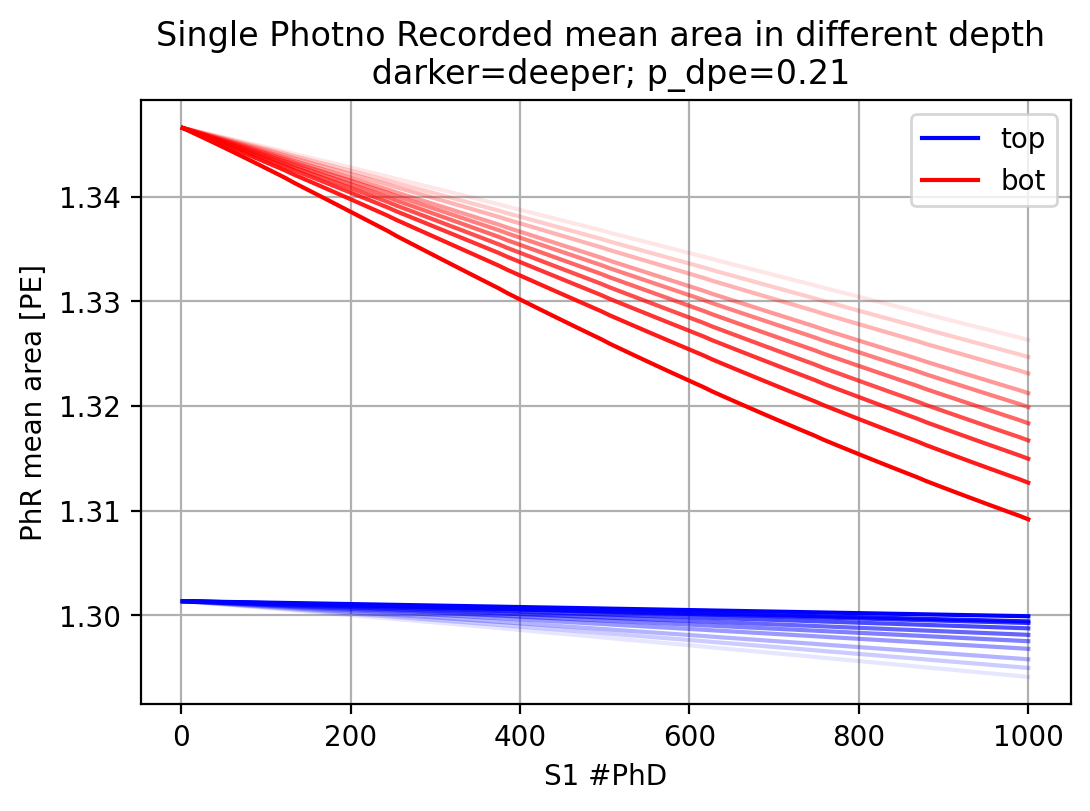

In [35]:
plt.figure(dpi=200)
plt.grid()
for z in range(10):
    if z == 0:
        plt.plot(n_phds, np.sum(sphr_areas_indices*avg_phr_area_top_zdpe[z,:,50,:],axis=1), color='b', label='top')
        plt.plot(n_phds, np.sum(sphr_areas_indices*avg_phr_area_bot_zdpe[z,:,50,:],axis=1), color='r', label='bot')
    else:
        plt.plot(n_phds, np.sum(sphr_areas_indices*avg_phr_area_top_zdpe[z,:,50,:],axis=1), color='b', alpha=1-0.1*z)
        plt.plot(n_phds, np.sum(sphr_areas_indices*avg_phr_area_bot_zdpe[z,:,50,:],axis=1), color='r', alpha=1-0.1*z)
    
plt.xlabel('S1 #PhD')
plt.legend()
plt.ylabel('PhR mean area [PE]')
plt.title('Single Photno Recorded mean area in different depth \n darker=deeper; p_dpe=0.21')



Let's check if $f_g$ is monotonic.

Text(0.5, 1.0, 'Average PhD per PE reconstructed $f_g$ in different depth \n darker=deeper; p_dpe=0.21')

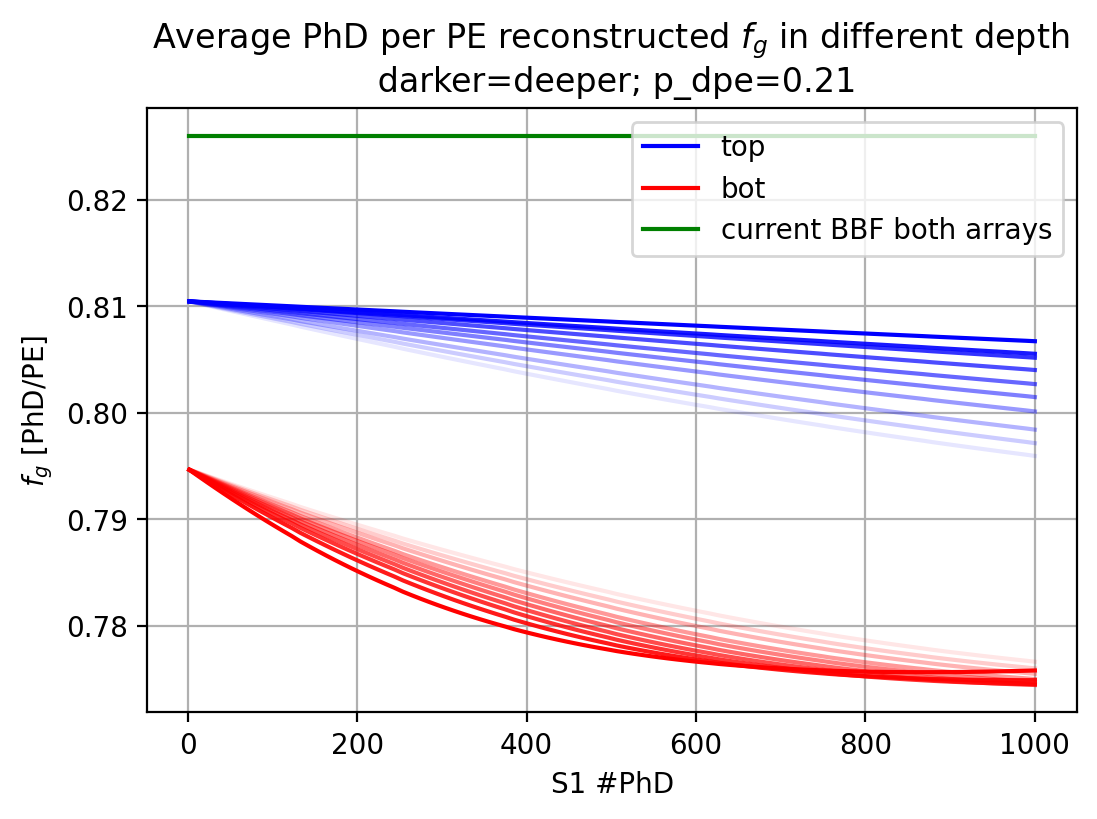

In [34]:
plt.figure(dpi=200)
plt.grid()
for z in range(10):
    if z == 0:
        plt.plot(n_phds, 1/(avg_phd_acc_top_zdpe[z,:,50] * np.sum(sphr_areas_indices*avg_phr_area_top_zdpe[z,:,50,:],axis=1)), color='b', label='top')
        plt.plot(n_phds, 1/(avg_phd_acc_bot_zdpe[z,:,50] * np.sum(sphr_areas_indices*avg_phr_area_bot_zdpe[z,:,50,:],axis=1)), color='r', label='bot')
    else:
        plt.plot(n_phds,1/(avg_phd_acc_top_zdpe[z,:,50] * np.sum(sphr_areas_indices*avg_phr_area_top_zdpe[z,:,50,:],axis=1)), color='b', alpha=1-0.1*z)
        plt.plot(n_phds,1/(avg_phd_acc_bot_zdpe[z,:,50] * np.sum(sphr_areas_indices*avg_phr_area_bot_zdpe[z,:,50,:],axis=1)), color='r', alpha=1-0.1*z)

plt.plot(n_phds, np.ones(len(n_phds))*0.826, color='g', label='current BBF both arrays')

plt.xlabel('S1 #PhD')
plt.legend()
plt.ylabel('$f_g$ [PhD/PE]')
plt.title('Average PhD per PE reconstructed $f_g$ in different depth \n darker=deeper; p_dpe=0.21')

# Out-dated codes

In [ ]:
avg_phr_areas_bot = np.load('/home/yuanlq/xenon/combpile/maps/avg_phr_areas_bot.npy')
avg_phr_areas_top = np.load('/home/yuanlq/xenon/combpile/maps/avg_phr_areas_top.npy')

Text(0.5, 1.0, 'PhR area spectrum in top array')

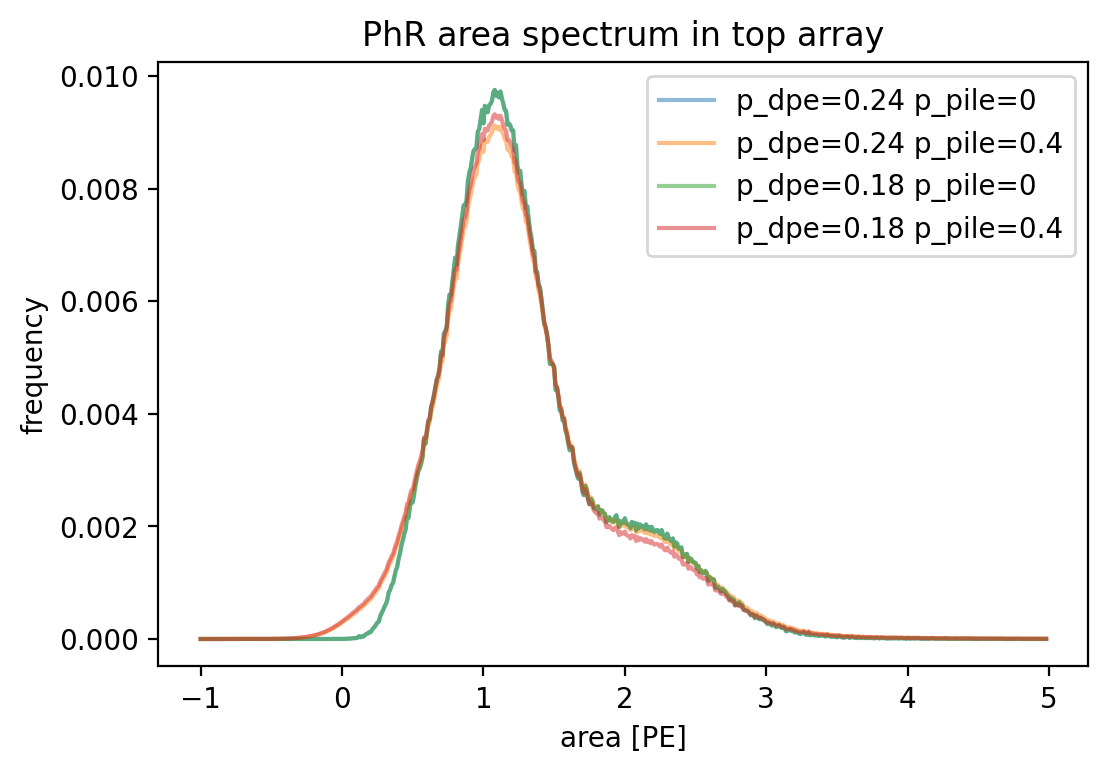

In [ ]:
plt.figure(dpi=200)
plt.plot(sphr_areas_indices, avg_phr_areas_top[-1,0,:], label='p_dpe=0.24 p_pile=0',alpha=0.5)
plt.plot(sphr_areas_indices, avg_phr_areas_top[-1,-1,:], label='p_dpe=0.24 p_pile=0.4',alpha=0.5)
plt.plot(sphr_areas_indices, avg_phr_areas_top[0,0,:], label='p_dpe=0.18 p_pile=0',alpha=0.5)
plt.plot(sphr_areas_indices, avg_phr_areas_top[0,-1,:], label='p_dpe=0.18 p_pile=0.4',alpha=0.5)
plt.legend()
plt.xlabel('area [PE]')
plt.ylabel('frequency')
plt.title('PhR area spectrum in top array')

Text(0.5, 1.0, 'PhR area spectrum in bottom array')

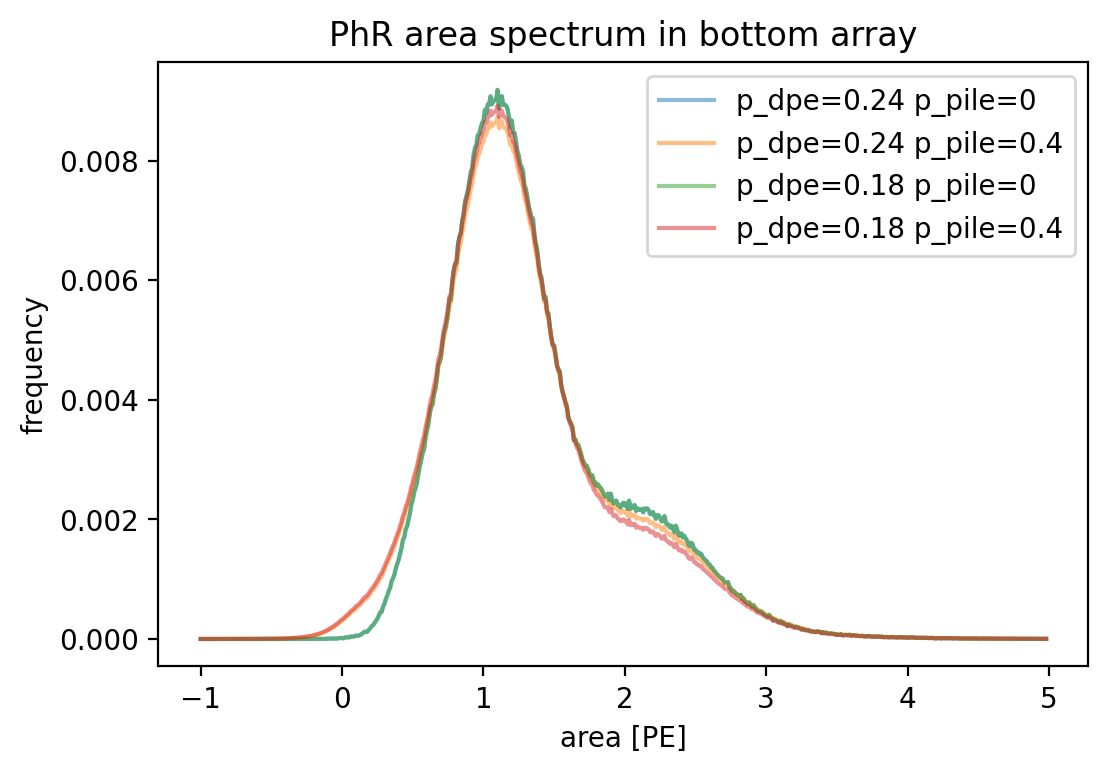

In [ ]:
plt.figure(dpi=200)
plt.plot(sphr_areas_indices, avg_phr_areas_bot[-1,0,:], label='p_dpe=0.24 p_pile=0',alpha=0.5)
plt.plot(sphr_areas_indices, avg_phr_areas_bot[-1,-1,:], label='p_dpe=0.24 p_pile=0.4',alpha=0.5)
plt.plot(sphr_areas_indices, avg_phr_areas_bot[0,0,:], label='p_dpe=0.18 p_pile=0',alpha=0.5)
plt.plot(sphr_areas_indices, avg_phr_areas_bot[0,-1,:], label='p_dpe=0.18 p_pile=0.4',alpha=0.5)
plt.legend()
plt.xlabel('area [PE]')
plt.ylabel('frequency')
plt.title('PhR area spectrum in bottom array')